In [76]:
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import re
import matplotlib
from src.utils import get_auc, get_empirical_cdf, get_all, _process_evalharness_results, get_superglue_results
import pandas as pd
import seaborn as sns

from src.figure_plotting_utils import *

In [77]:
plt.rcParams.update({
    # Fonts (increased further for visibility)
    'font.size': 28,                      # Default font size
    'font.family': 'serif',               # Set font family to 'serif'
    'font.serif': ['Times New Roman', 'DejaVu Math TeX Gyre', 'DejaVu Serif'],  # Serif fonts
    'axes.titlesize': 30,                 # Title font size (even larger)
    'axes.labelsize': 30,                 # Axis label font size
    'legend.fontsize': 26,                # Legend font size
    'xtick.labelsize': 24,                # X-tick label font size
    'ytick.labelsize': 24,                # Y-tick label font size
    
    # Figure size and DPI
    'figure.figsize': [10, 8],            # Same figure size, but adjust as needed
    'figure.dpi': 100,                    # Higher resolution for clarity
    
    # Line properties
    'lines.linewidth': 4,                 # Default line thickness
    'lines.markersize': 15,               # Marker size
    
    # Axes
    'axes.grid': True,                    # Grid on
    'grid.color': 'gray',                 # Grid color
    'grid.linestyle': '-',                # Solid grid line style
    'grid.linewidth': 0.75,               # Grid line width
    'axes.edgecolor': 'black',            # Axes border color
    'axes.linewidth': 1.5,                # Thicker axes border
    'axes.titleweight': 'bold',           # Bold titles
    
    # Set default x-axis to start at 0
    'axes.autolimit_mode': 'round_numbers',  # Round axis limits
    'axes.xmargin': 0.0,                    # Remove extra margin on x-axis
    'axes.ymargin': 0.05,                 # Slight y-axis margin
    
    # Ticks
    'xtick.major.size': 7,                # Major tick size
    'xtick.major.width': 1.5,             # Major tick width
    'ytick.major.size': 7,                # Major tick size
    'ytick.major.width': 1.5,             # Major tick width
    
    # Legend
    'legend.frameon': True,               # Frame around legend
    'legend.framealpha': 0.9,             # Slightly transparent frame
    'legend.fancybox': True,              # Rounded corners
    
    # Save figure
    'savefig.dpi': 300,                   # High resolution for saving
    'savefig.format': 'pdf',              # Save format
    'savefig.bbox': 'tight',              # Tight layout for saving
})
default_cycler = plt.rcParams['axes.prop_cycle']
default_cycler = [c['color'] for c in default_cycler]

In [78]:
TASKS = {
        'boolq':'acc',
        'cb':'acc',
        'copa':'acc',
        'multirc':'acc',
        'record': 'f1',
        'rte':'acc',
        'wic':'acc',
        'wsc':'acc',
        'gsm8k_cot_self_consistency': 'exact_match,flexible-extract'
    }

In [79]:
amlt_parent = '/home/blockadam/gaussian-watermarking/amlt'
figs_parent = '/home/blockadam/gaussian-watermarking/figs'
save_figs = True

# Helper Functions

# Getting Generations

In [80]:
amlt_parent = '/home/blockadam/gaussian-watermarking/amlt'

In [81]:
llama_parent = os.path.join(amlt_parent, '10-07-watermark-llama')


llama_generations = get_generations(llama_parent)['meta-llama/Meta-Llama-3.1-8B']
llama_metrics = get_metrics(llama_parent, include_unwatermarked=False)['meta-llama/Meta-Llama-3.1-8B']
llama_unwatermarked = get_unwatermarked_metrics('meta-llama/Meta-Llama-3.1-8B')[0]
llama_data = {key: get_all(llama_generations[key], 1e-20) for key in llama_generations.keys()}

Error processing /home/blockadam/gaussian-watermarking/amlt/10-07-watermark-llama/grid_10-07-watermark-llama_lay_31_mlp_down_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_0_var_1e-3: [Errno 2] No such file or directory: '/home/blockadam/gaussian-watermarking/amlt/10-07-watermark-llama/grid_10-07-watermark-llama_lay_31_mlp_down_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_0_var_1e-3/data/eval_results/results.json'


In [82]:
phi_parent = os.path.join(amlt_parent, '10-07-watermark-phi')


phi_generations = get_generations(phi_parent)['microsoft/Phi-3-mini-4k-instruct']
phi_metrics = get_metrics(phi_parent, include_unwatermarked=False)['microsoft/Phi-3-mini-4k-instruct']
phi_unwatermarked = get_unwatermarked_metrics('microsoft/Phi-3-mini-4k-instruct')[0]
phi_data = {key: get_all(phi_generations[key], 1e-20) for key in phi_generations.keys()}

In [83]:
mistral_parent = os.path.join(amlt_parent, '10-07-watermark-mistral')

mistral_generations = get_generations(mistral_parent)['mistralai/Mistral-7B-v0.3']
mistral_metrics = get_metrics(mistral_parent, include_unwatermarked=False)['mistralai/Mistral-7B-v0.3']
mistral_unwatermarked = get_unwatermarked_metrics('mistralai/Mistral-7B-v0.3')[0]
mistral_data = {key: get_all(mistral_generations[key], 1e-20) for key in mistral_generations.keys()}

[Errno 2] No such file or directory: '/home/blockadam/gaussian-watermarking/amlt/10-07-watermark-mistral/grid_10-07-watermark-mistral_lay_30_mlp_down_proj_mod_mistralai_Mistral-7B-v0.3_ran_0_var_1e-4/generations.json'
Error processing /home/blockadam/gaussian-watermarking/amlt/10-07-watermark-mistral/grid_10-07-watermark-mistral_lay_30_mlp_down_proj_mod_mistralai_Mistral-7B-v0.3_ran_0_var_1e-4


# Plots by layer

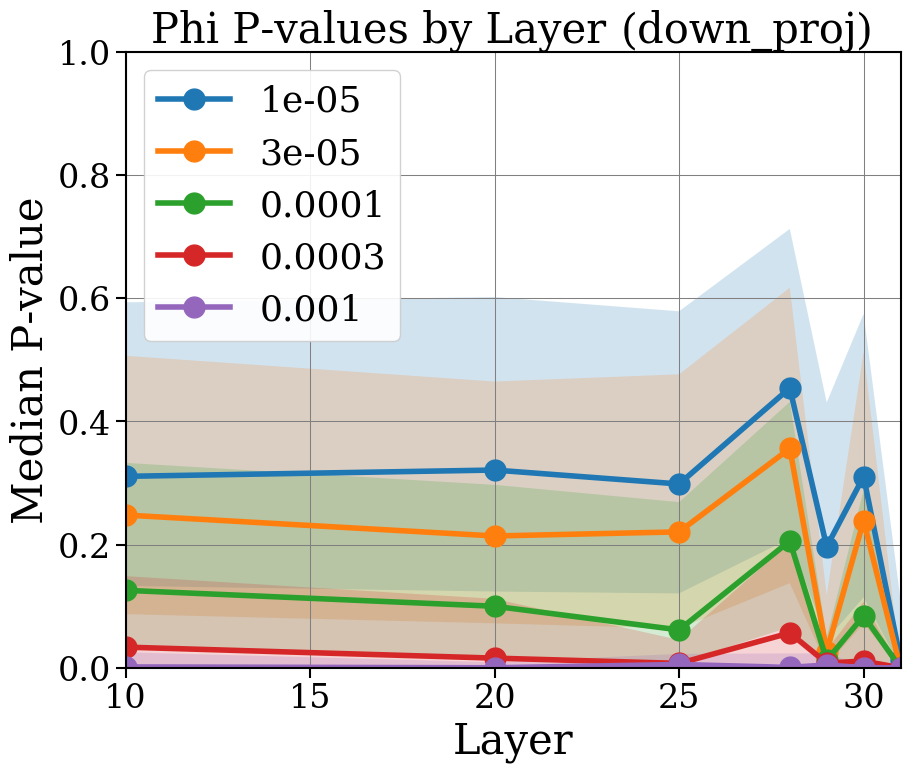

In [84]:
model = 'Phi'
mlp_type = 'down_proj'
# mlp_type = 'gate_up_proj'
title = f"{model} P-values by Layer ({mlp_type})"


fig, ax = plot_by_layer_mlptype(phi_data, mlp_type, title, use_log=False)
ax.set_xlim(10,31)
ax.set_ylim(0, 1.0)
plt.show()

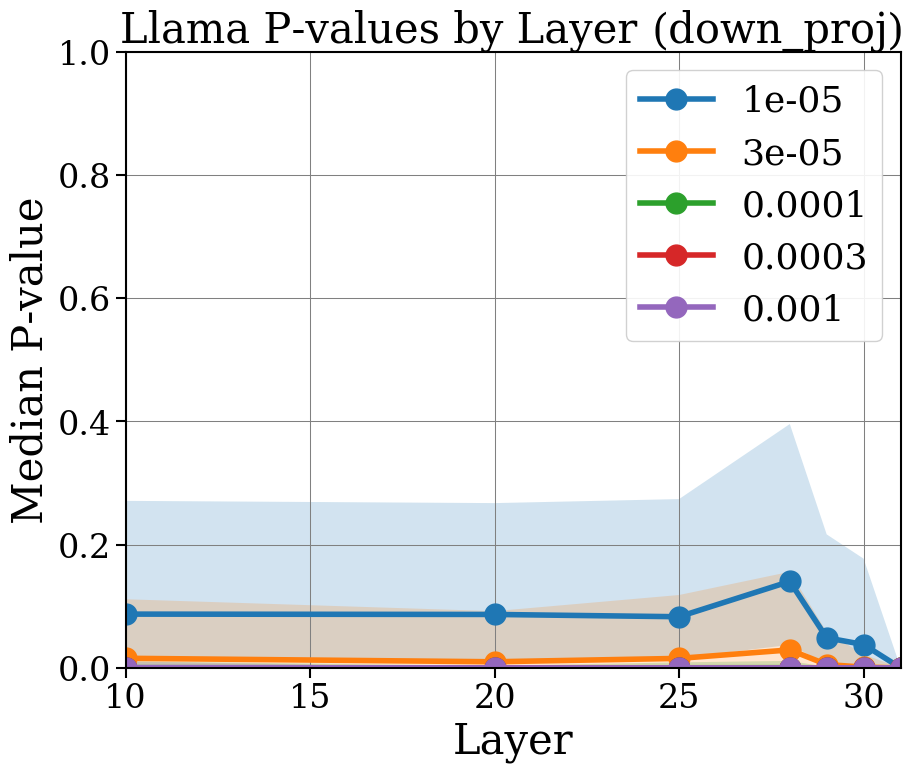

In [85]:
model = 'Llama'
mlp_type = 'down_proj'
# mlp_type = 'up_proj'
# mlp_type = 'gate_proj'
title = f"{model} P-values by Layer ({mlp_type})"


fig, ax = plot_by_layer_mlptype(llama_data, mlp_type, title, use_log=False)
ax.set_xlim(10,31)
ax.set_ylim(0, 1.0)
plt.show()

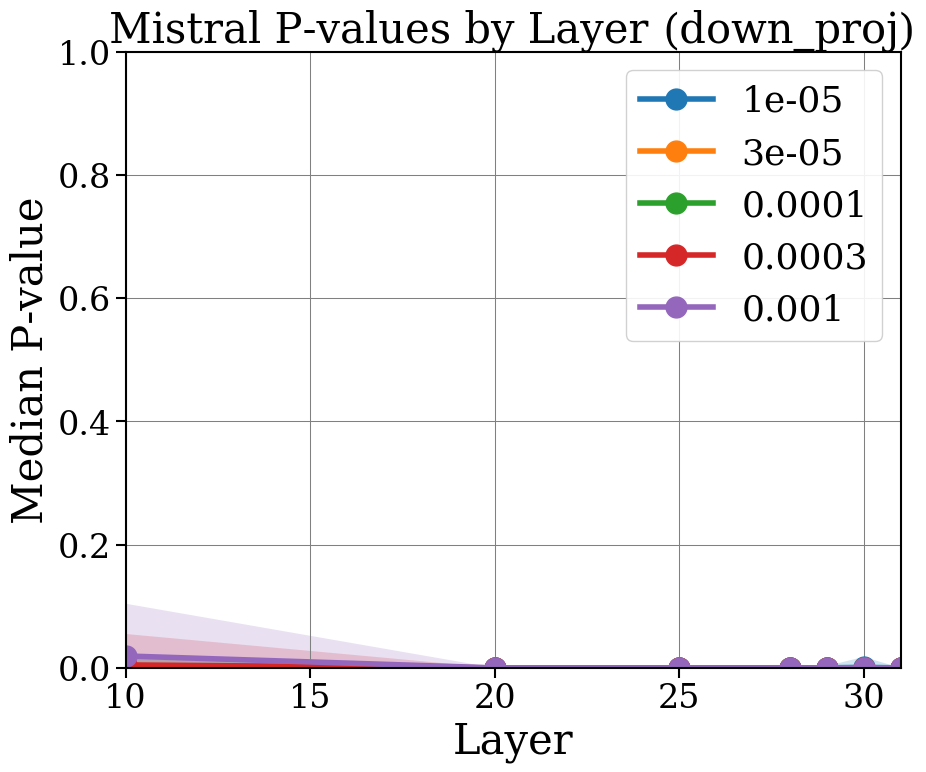

In [86]:
model = 'Mistral'
mlp_type = 'down_proj'
# mlp_type = 'up_proj'
# mlp_type = 'gate_proj'
title = f"{model} P-values by Layer ({mlp_type})"


fig, ax = plot_by_layer_mlptype(mistral_data, mlp_type, title, use_log=False)
ax.set_xlim(10,31)
ax.set_ylim(0, 1.0)
plt.show()

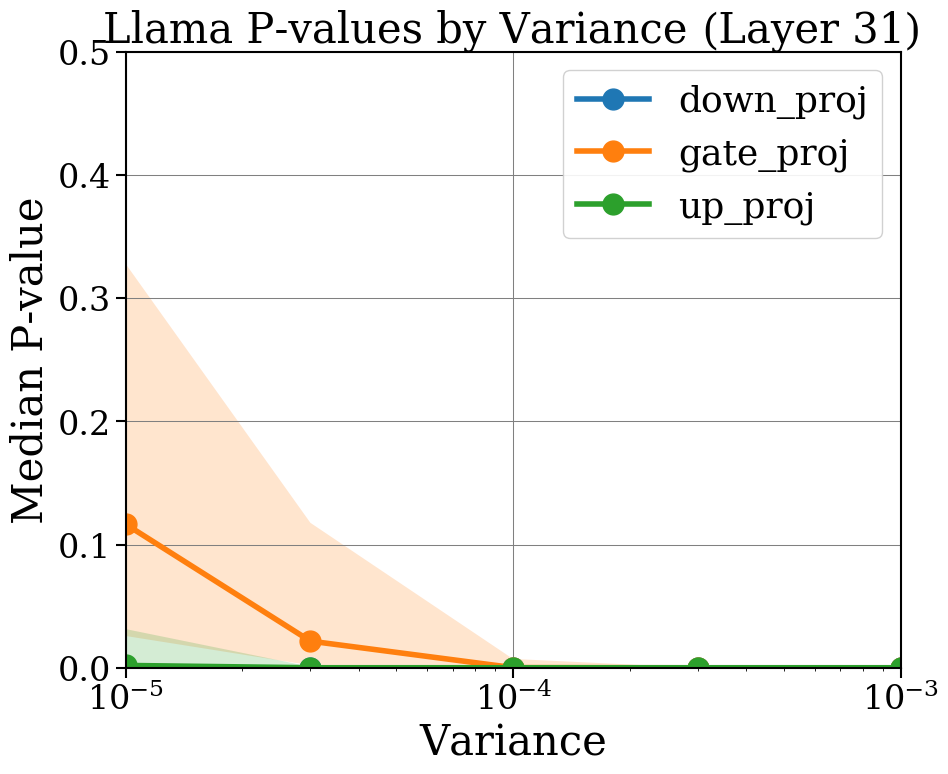

In [87]:

model = 'Llama'
fixed_layer = 31
title = f"{model} P-values by Variance (Layer {fixed_layer})"


fig, ax = plot_by_variance_layer(llama_data, fixed_layer, title, use_log=False)
ax.set_xscale('log')
ax.set_xlim(1e-5, 1e-3)
ax.set_ylim(0,0.5)
plt.show()

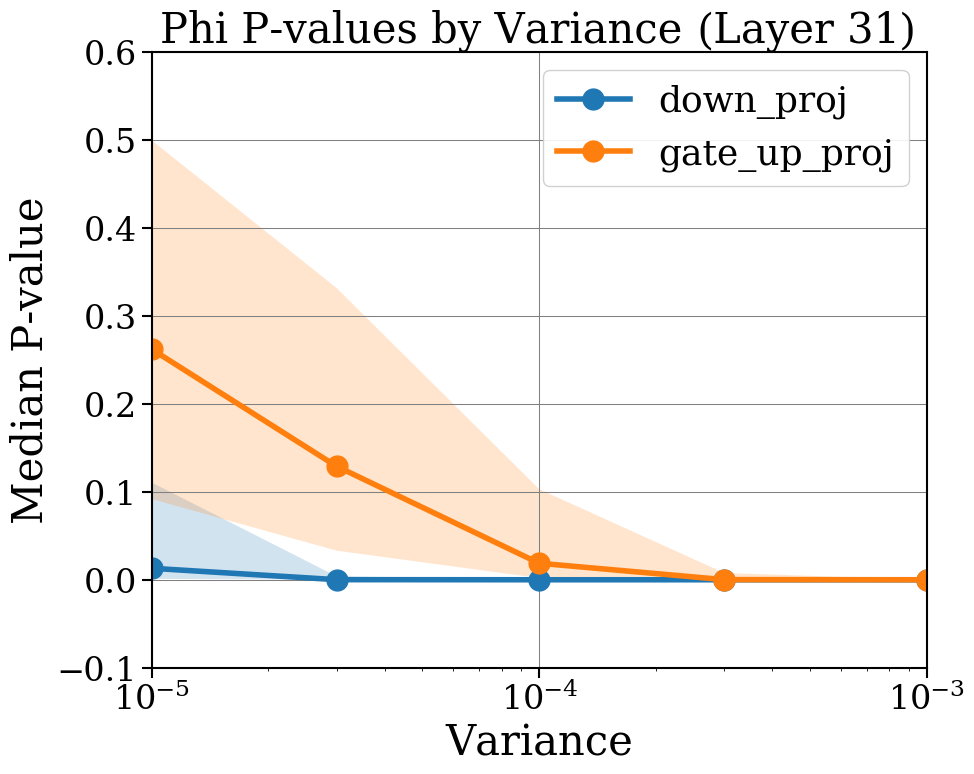

In [88]:
model = 'Phi'
title = f"{model} P-values by Variance (Layer {fixed_layer})"


fig, ax = plot_by_variance_layer(phi_data, fixed_layer, title, use_log=False)
ax.set_xscale('log')
ax.set_xlim(1e-5, 1e-3)
plt.show()

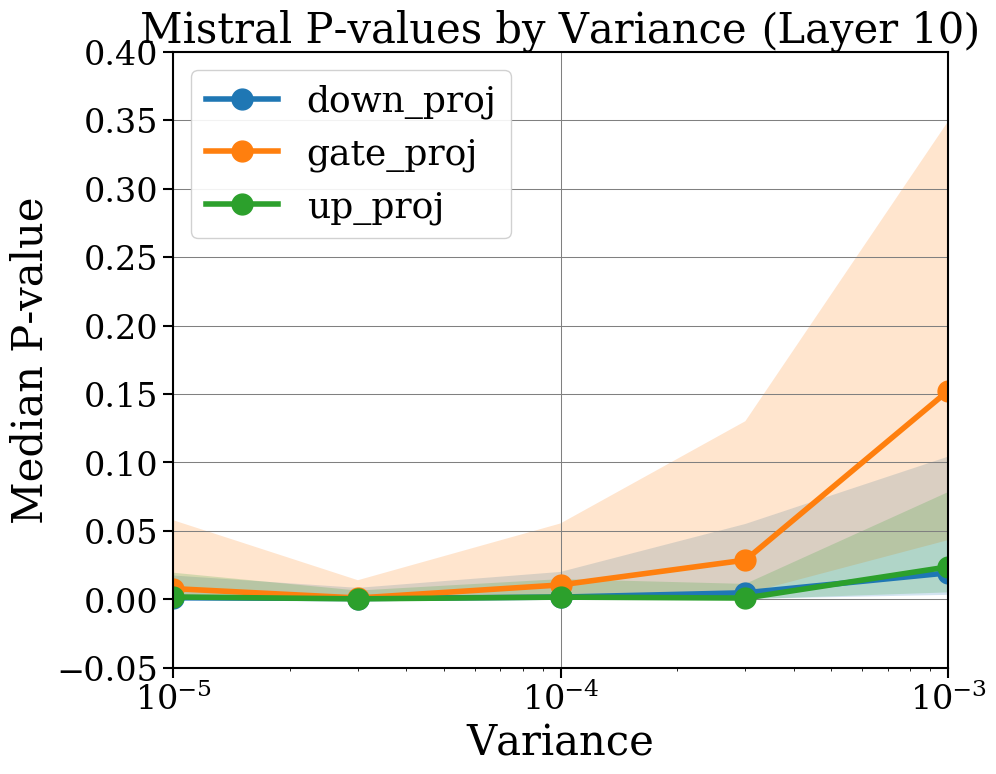

In [89]:

model = 'Mistral'
fixed_layer = 10
title = f"{model} P-values by Variance (Layer {fixed_layer})"


fig, ax = plot_by_variance_layer(mistral_data, fixed_layer, title, use_log=False)
# ax.set_title("Mistral P-values (Layer 10)")
ax.set_xscale('log')
ax.set_xlim(1e-5, 1e-3)
# ax.set_ylim(0,0.5)

if save_figs:
    fig.savefig(os.path.join(figs_parent, f"pvalues_mistral_variance_layer_{fixed_layer}.pdf"))

plt.show()

# Colored Tables of median P-values

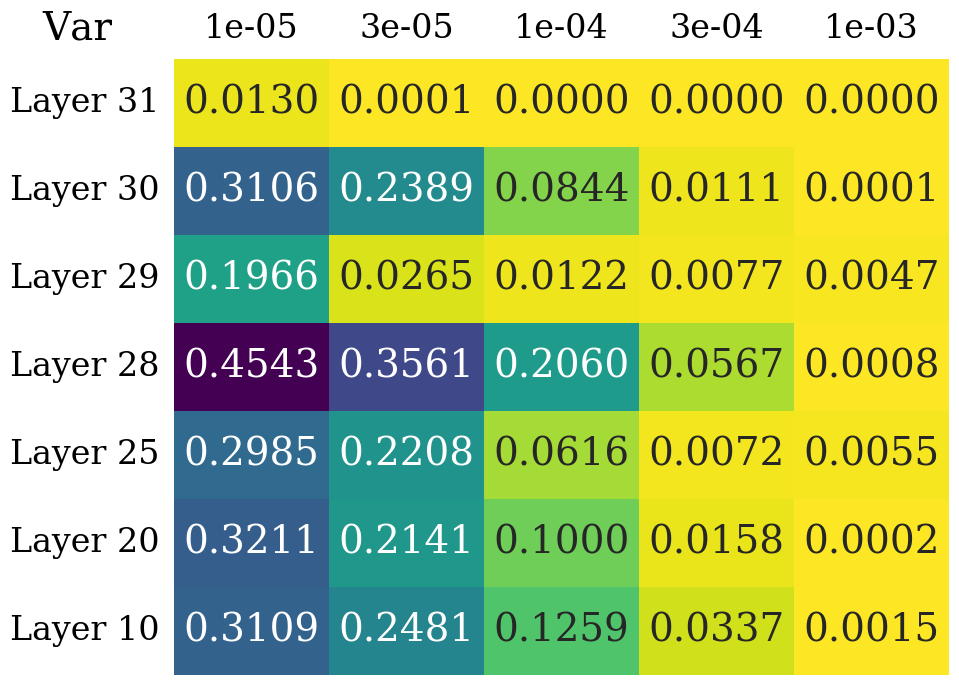

In [90]:
model = 'Phi'
fixed_mlp_type = 'down_proj'
fig, ax = get_pval_colored_tables(phi_data, fixed_mlp_type)
title = f"{model} Median P-values ({fixed_mlp_type})"
# ax.set_title(title, y=1.12)
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"pvalues_phi_median_{fixed_mlp_type}.pdf"))

plt.show()

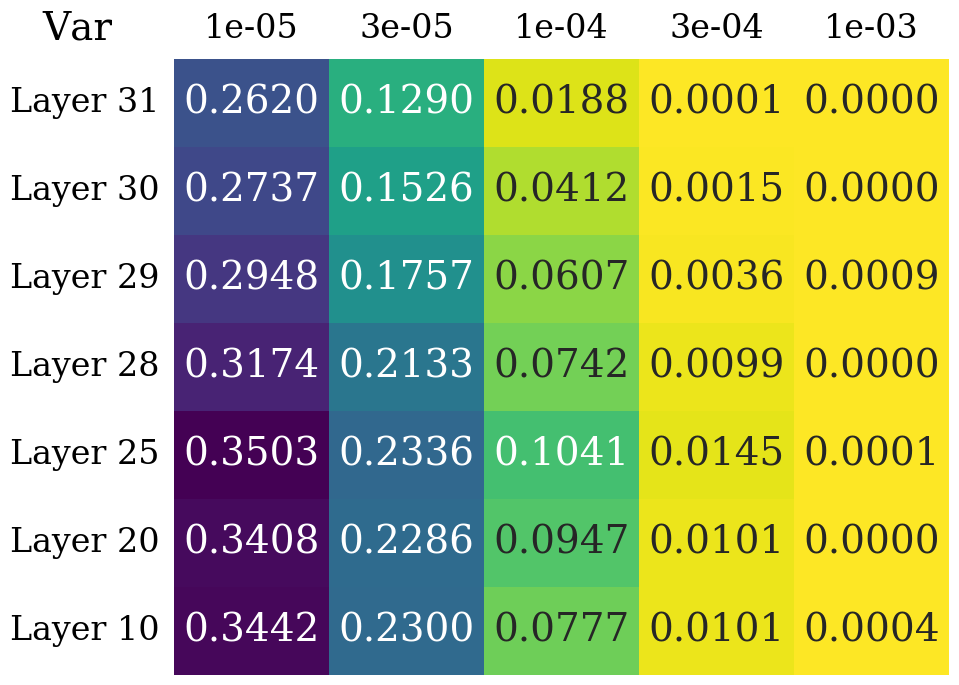

In [91]:
model = 'Phi'
fixed_mlp_type = 'gate_up_proj'
fig, ax = get_pval_colored_tables(phi_data, fixed_mlp_type)
title = f"{model} Median P-values ({fixed_mlp_type})"
# ax.set_title(title, y=1.12)
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"pvalues_phi_median_{fixed_mlp_type}.pdf"))

plt.show()

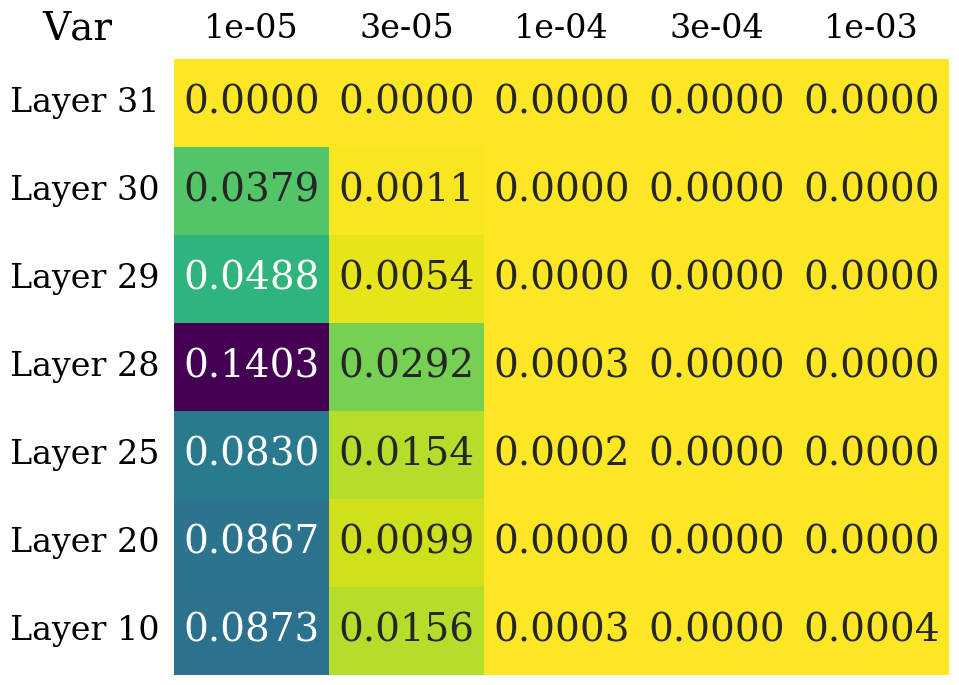

In [92]:
model = 'Llama'
fixed_mlp_type = 'down_proj'
fig, ax = get_pval_colored_tables(llama_data, fixed_mlp_type)
title = f"{model} Median P-values ({fixed_mlp_type})"
# ax.set_title(title, y=1.12)
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"pvalues_llama_median_{fixed_mlp_type}.pdf"))
plt.show()

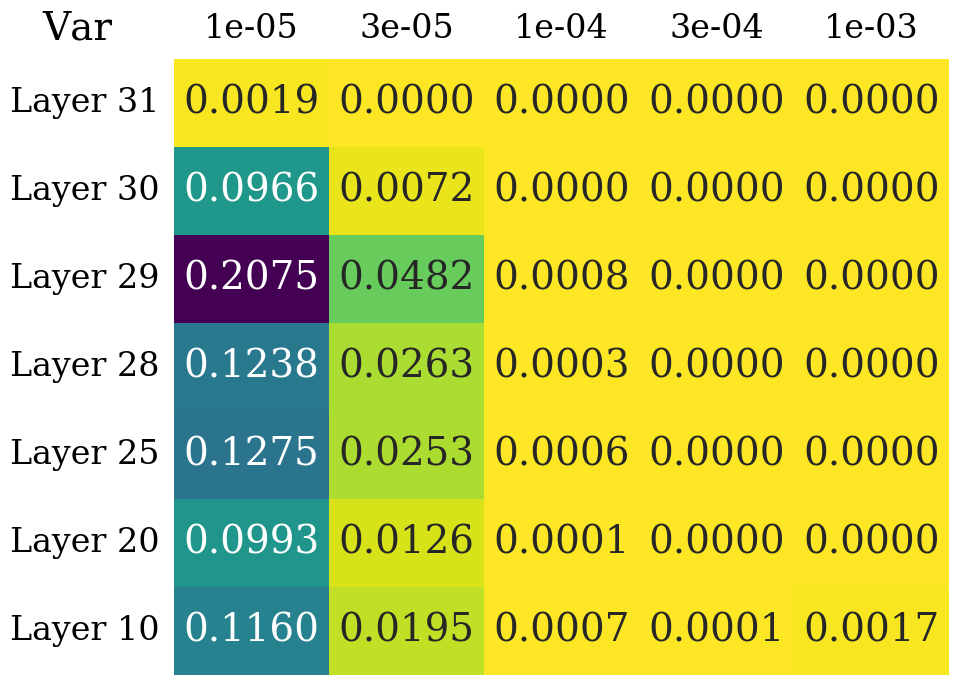

In [93]:
model = 'Llama'
fixed_mlp_type = 'up_proj'
fig, ax = get_pval_colored_tables(llama_data, fixed_mlp_type)
title = f"{model} Median P-values ({fixed_mlp_type})"
# ax.set_title(title, y=1.12)
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"pvalues_llama_median_{fixed_mlp_type}.pdf"))
plt.show()

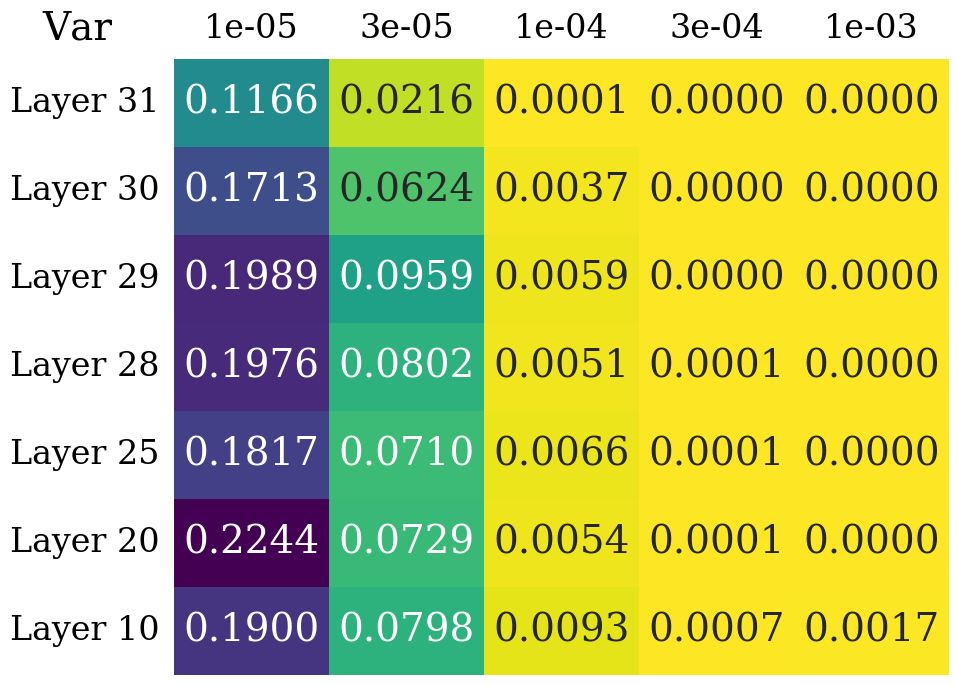

In [94]:
model = 'Llama'
fixed_mlp_type = 'gate_proj'
fig, ax = get_pval_colored_tables(llama_data, fixed_mlp_type)
title = f"{model} Median P-values ({fixed_mlp_type})"
# ax.set_title(title, y=1.12)
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"pvalues_llama_median_{fixed_mlp_type}.pdf"))
plt.show()

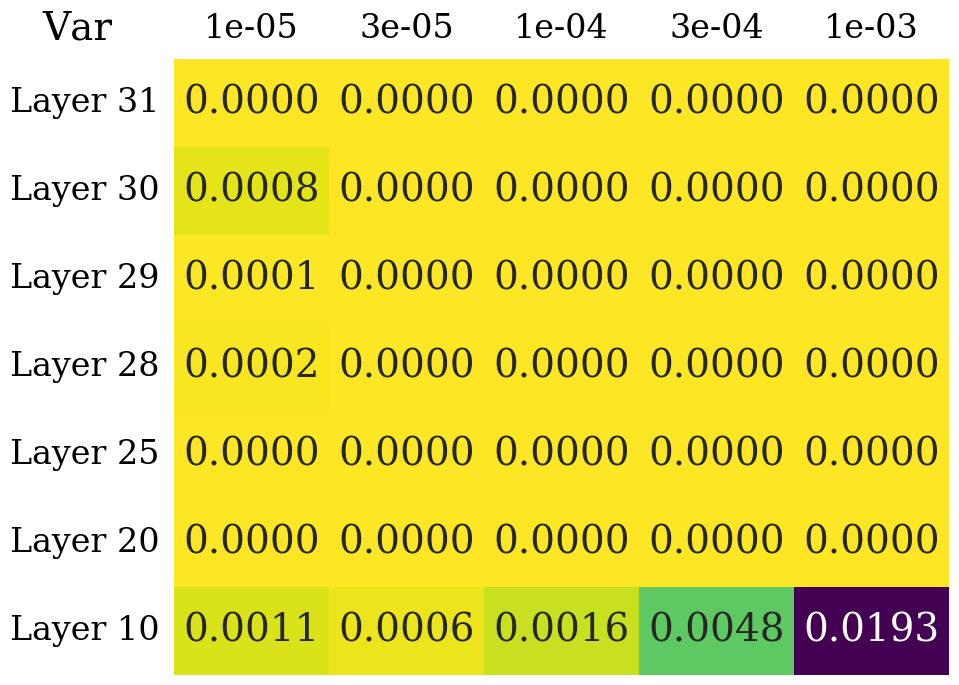

In [95]:
model = 'Mistral'
fixed_mlp_type = 'down_proj'
fig, ax = get_pval_colored_tables(mistral_data, fixed_mlp_type)
title = f"{model} Median P-values ({fixed_mlp_type})"
# ax.set_title(title, y=1.12)
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"pvalues_mistral_median_{fixed_mlp_type}.pdf"))
plt.show()

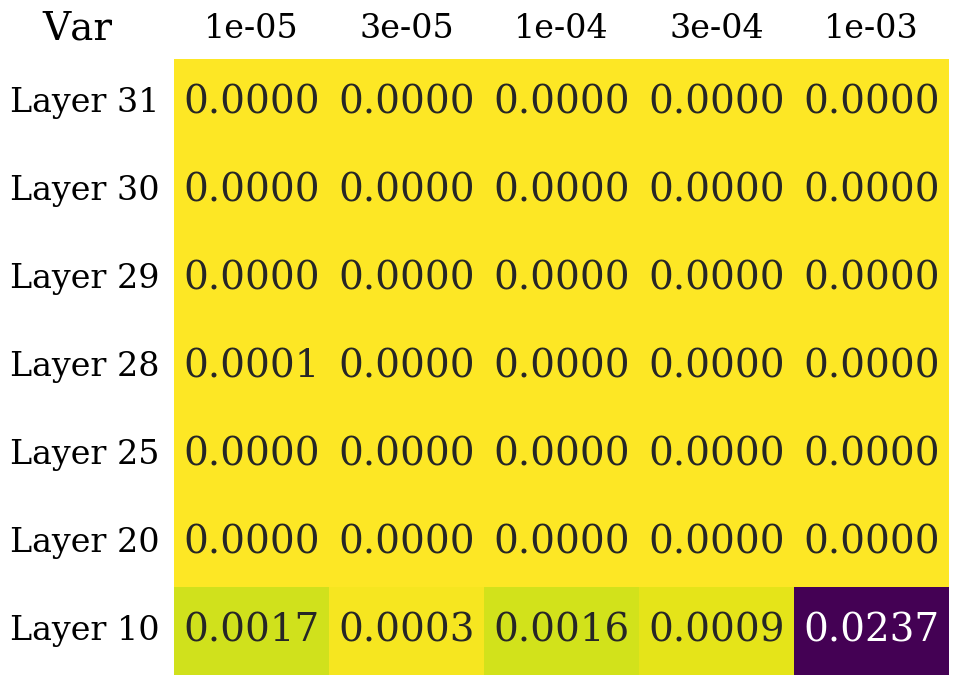

In [96]:
model = 'Mistral'
fixed_mlp_type = 'up_proj'
fig, ax = get_pval_colored_tables(mistral_data, fixed_mlp_type)
title = f"{model} Median P-values ({fixed_mlp_type})"
# ax.set_title(title, y=1.12)
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"pvalues_mistral_median_{fixed_mlp_type}.pdf"))
plt.show()

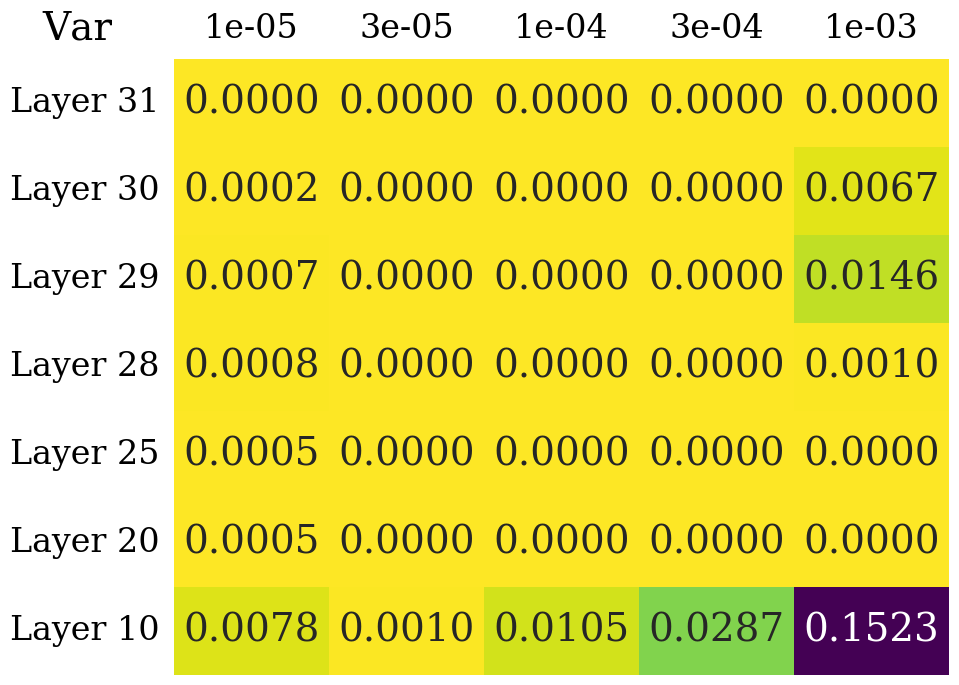

In [97]:
model = 'Mistral'
fixed_mlp_type = 'gate_proj'
fig, ax = get_pval_colored_tables(mistral_data, fixed_mlp_type)
title = f"{model} Median P-values ({fixed_mlp_type})"
# ax.set_title(title, y=1.12)
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"pvalues_mistral_median_{fixed_mlp_type}.pdf"))
plt.show()

# Plotting Metrics

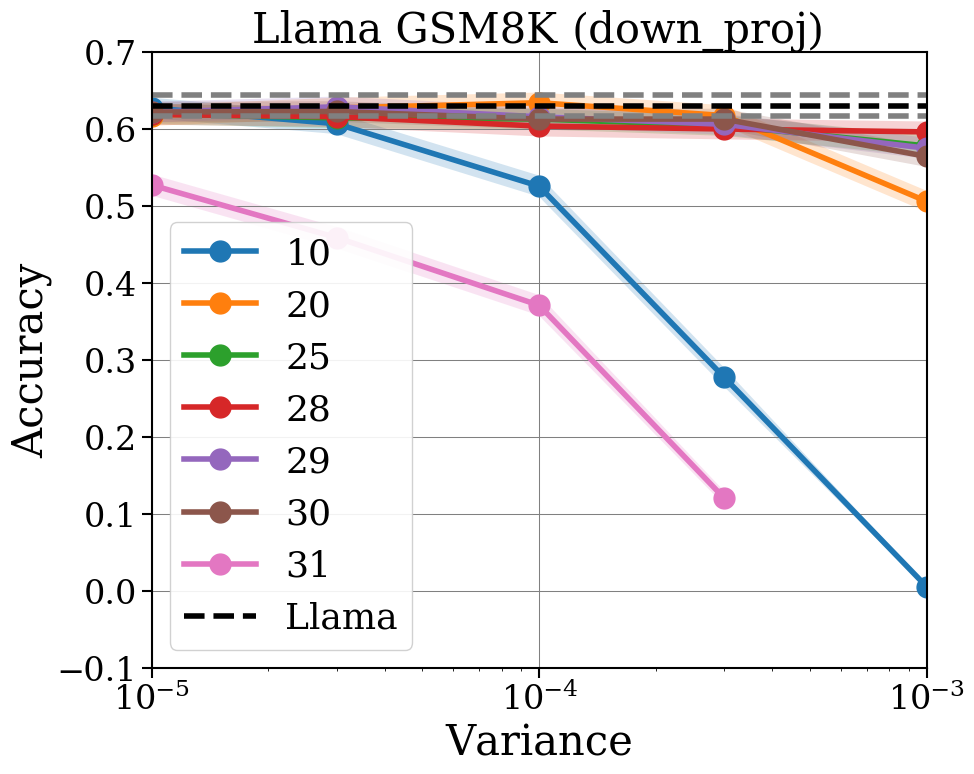

In [98]:
model = 'Llama'
# task = 'boolq'
# task = 'record'
# task = 'wic'
# task = 'multirc'
# task = 'cb'
# task = 'copa'
# task = 'rte'
# task = 'wsc'
task = 'gsm8k_cot_self_consistency'
fixed_mlp_type = 'down_proj'
if task == 'wsc':
    task_name = 'Winograd'
elif task == 'boolq':
    task_name = 'BoolQ'
elif task == 'gsm8k_cot_self_consistency':
    task_name = 'GSM8K'
else:
    task_name = task
    
title = f"{model} {task_name} ({fixed_mlp_type})"

fig, ax = plot_metric_by_variance_mlp_type(llama_metrics, llama_unwatermarked, task, fixed_mlp_type, title)
ax.set_xlim(1e-5, 1e-3)
ax.legend(loc='lower left')

if save_figs:
    fig.savefig(os.path.join(figs_parent, f"llama_{task}_{fixed_mlp_type}.pdf"))

plt.show()

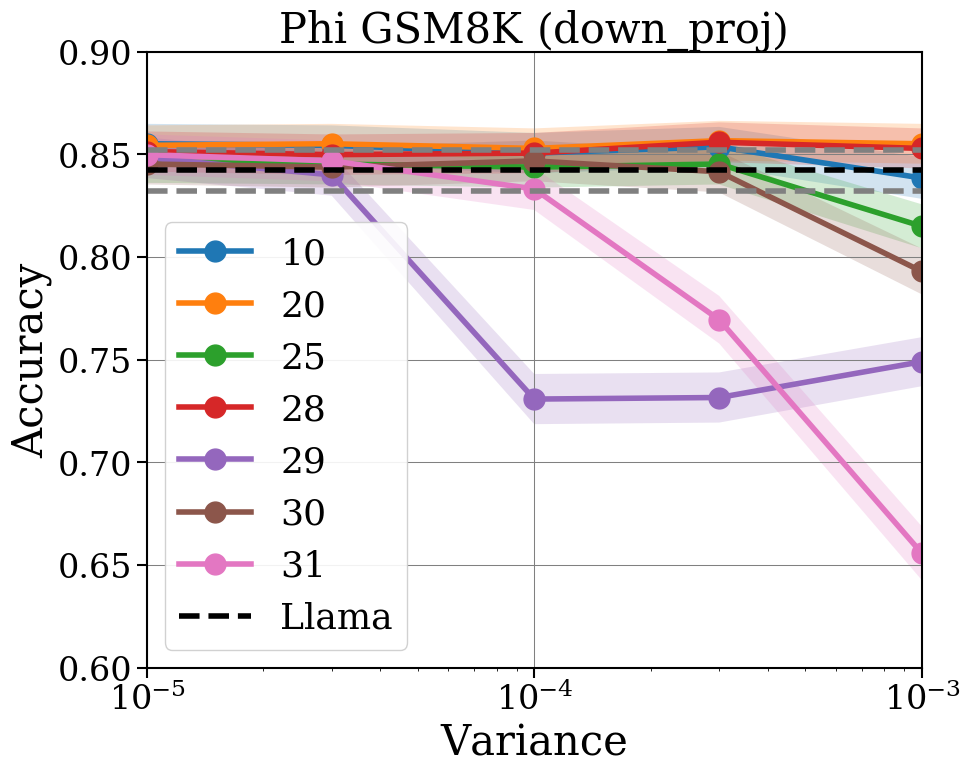

In [99]:
model = 'Phi'
fixed_mlp_type = 'down_proj'
title = f"{model} {task_name} ({fixed_mlp_type})"

fig, ax = plot_metric_by_variance_mlp_type(phi_metrics,phi_unwatermarked, task, fixed_mlp_type, title)
ax.set_xlim(1e-5, 1e-3)
ax.legend(loc='lower left')
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"phi_{task}_{fixed_mlp_type}.pdf"))
plt.show()

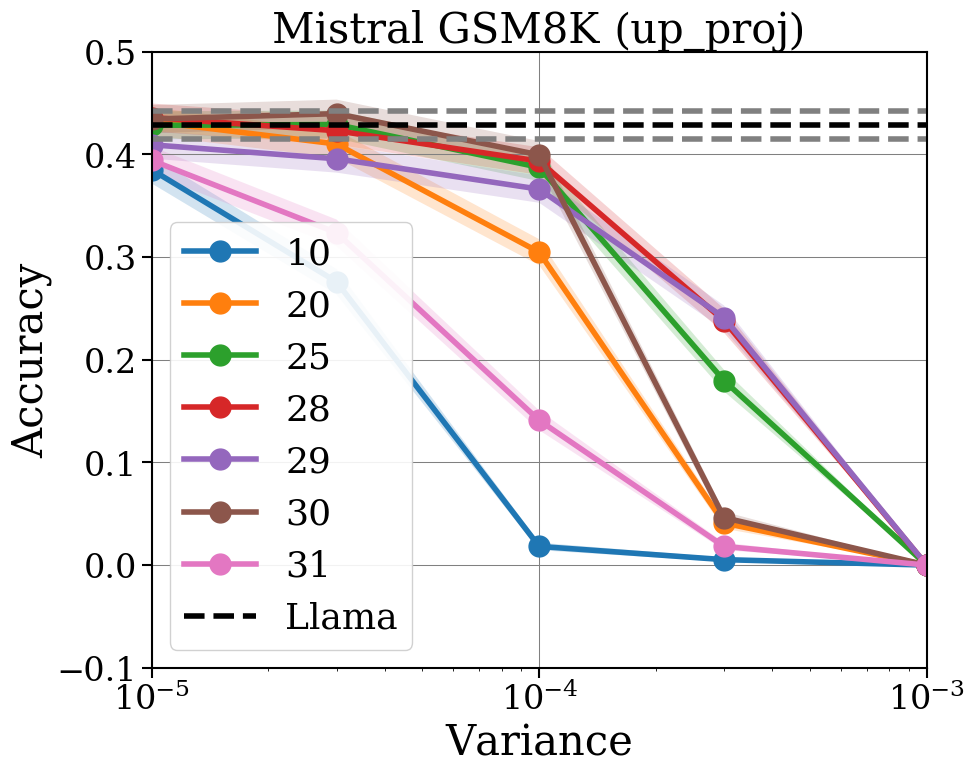

In [100]:
model = 'Mistral'

fixed_mlp_type = 'up_proj'
title = f"{model} {task_name} ({fixed_mlp_type})"

fig, ax = plot_metric_by_variance_mlp_type(mistral_metrics,mistral_unwatermarked, task, fixed_mlp_type, title)
ax.set_xlim(1e-5, 1e-3)
ax.legend(loc='lower left')
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"mistral_{task}_{fixed_mlp_type}.pdf"))
plt.show()

# Tables of Metrics

Unwatermarked: 0.5752 +/- 0.0196
Unwatermarked (Normalized): (0.9660, 1.0340)


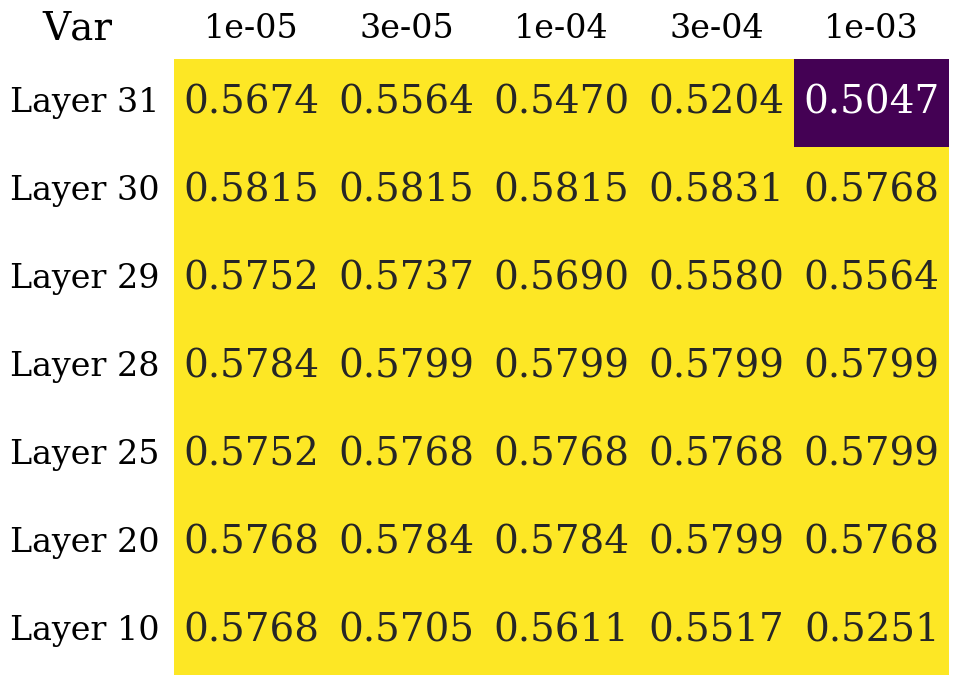

In [101]:
# task = 'boolq'
# task = 'record'
task = 'wic'
# task = 'multirc'
# task = 'cb'
# task = 'copa'
# task = 'rte'
# task = 'wsc'



model = 'Phi'
fixed_mlp_type = 'down_proj'

title = f"{model} {task} ({fixed_mlp_type})"

fig, ax = get_superglue_colored_tables(phi_metrics, phi_unwatermarked, task, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = phi_unwatermarked[task][TASKS[task]]
unwat_std = phi_unwatermarked[task][TASKS[task] + '_stderr']
print(f"Unwatermarked: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")
plt.show()

Unwatermarked: 0.5752 +/- 0.0196
Unwatermarked (Normalized): (0.9660, 1.0340)


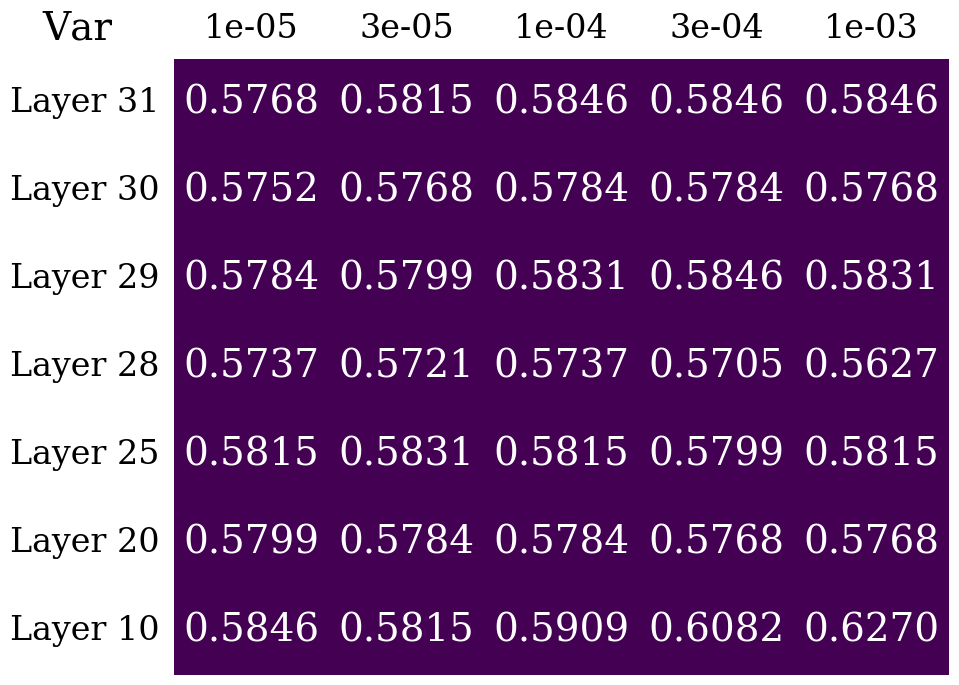

In [102]:
fixed_mlp_type = 'gate_up_proj'

title = f"{model} {task} ({fixed_mlp_type})"

fig, ax = get_superglue_colored_tables(phi_metrics, phi_unwatermarked, task, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = phi_unwatermarked[task][TASKS[task]]
unwat_std = phi_unwatermarked[task][TASKS[task] + '_stderr']
print(f"Unwatermarked: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")
plt.show()

Unwatermarked: 0.5157 +/- 0.0198
Unwatermarked (Normalized): (0.9616, 1.0384)


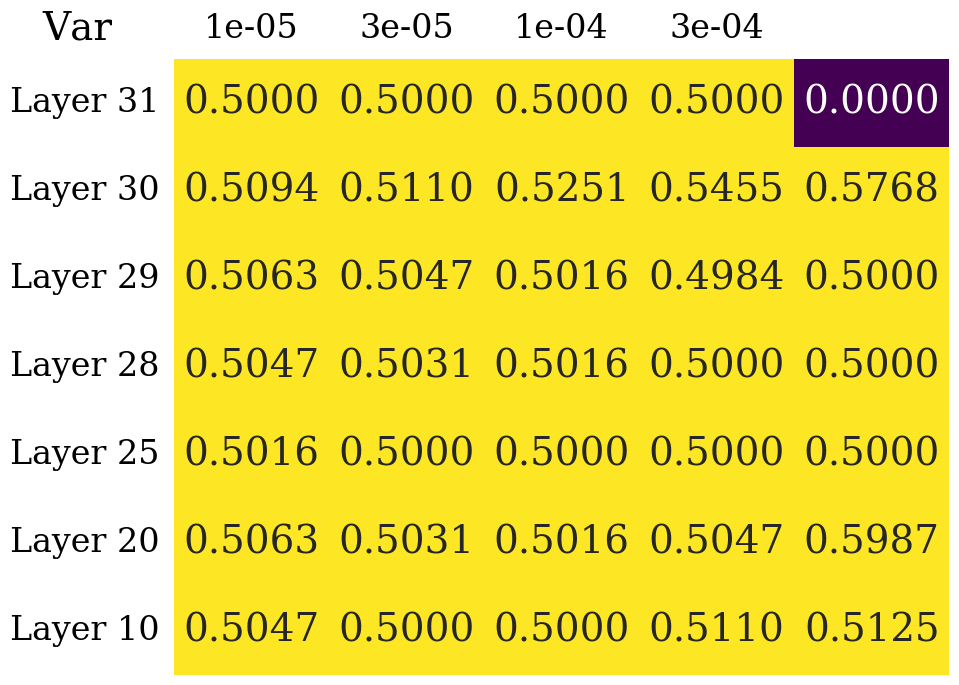

In [103]:
model = 'Llama'
fixed_mlp_type = 'down_proj'
title = f"{model} {task} ({fixed_mlp_type})"

fig, ax = get_superglue_colored_tables(llama_metrics, llama_unwatermarked, task, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = llama_unwatermarked[task][TASKS[task]]
unwat_std = llama_unwatermarked[task][TASKS[task] + '_stderr']
print(f"Unwatermarked: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")
plt.show()

Unwatermarked: 0.5157 +/- 0.0198
Unwatermarked (Normalized): (0.9616, 1.0384)


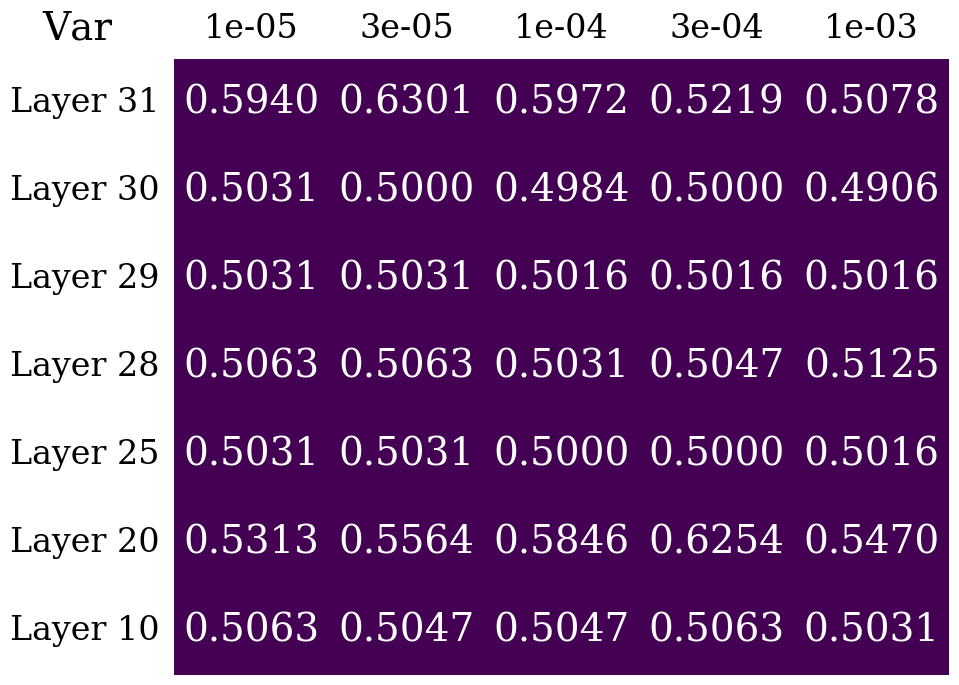

In [104]:
model = 'Llama'
fixed_mlp_type = 'up_proj'
title = f"{model} {task} ({fixed_mlp_type})"

fig, ax = get_superglue_colored_tables(llama_metrics, llama_unwatermarked, task, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = llama_unwatermarked[task][TASKS[task]]
unwat_std = llama_unwatermarked[task][TASKS[task] + '_stderr']
print(f"Unwatermarked: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")
plt.show()

Unwatermarked: 0.5157 +/- 0.0198
Unwatermarked (Normalized): (0.9616, 1.0384)


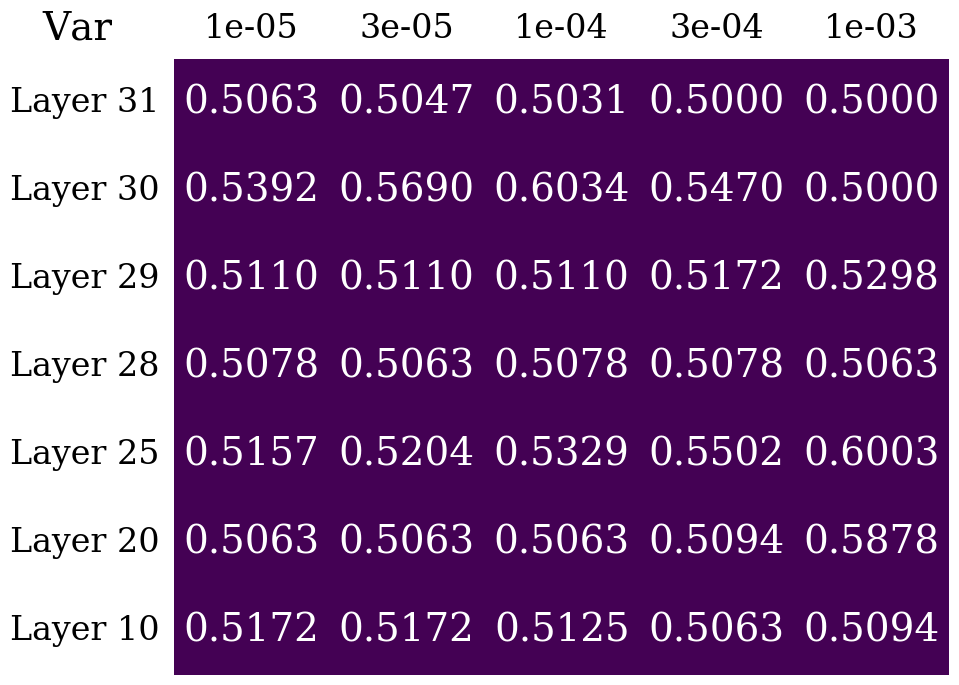

In [105]:
model = 'Llama'
fixed_mlp_type = 'gate_proj'
title = f"{model} {task} ({fixed_mlp_type})"

fig, ax = get_superglue_colored_tables(llama_metrics, llama_unwatermarked, task, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = llama_unwatermarked[task][TASKS[task]]
unwat_std = llama_unwatermarked[task][TASKS[task] + '_stderr']
print(f"Unwatermarked: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")
plt.show()

Unwatermarked: 0.5157 +/- 0.0198
Unwatermarked (Normalized): (0.9616, 1.0384)


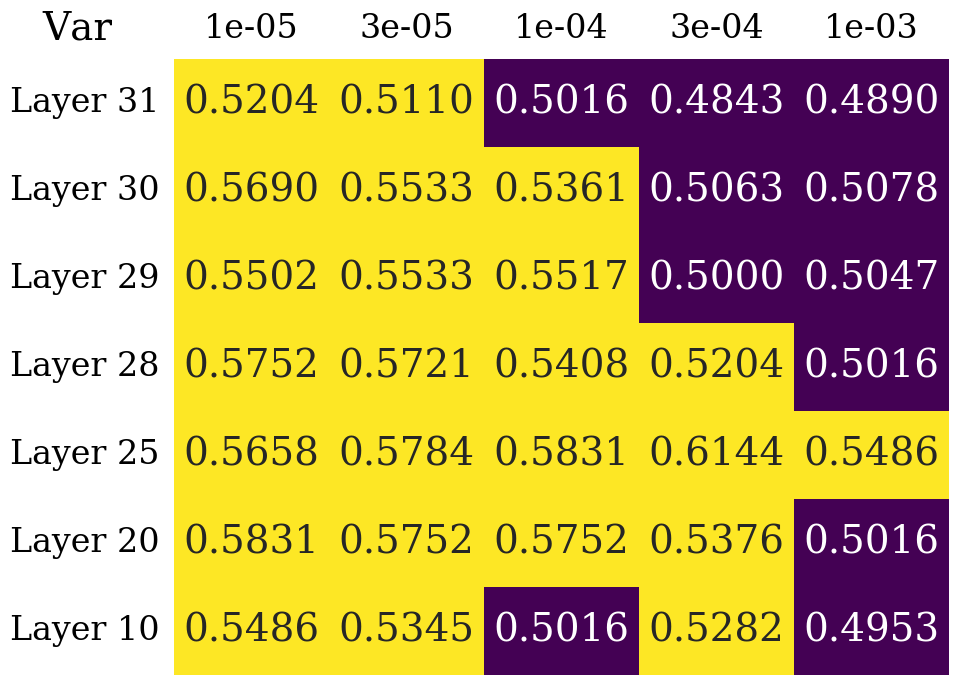

In [106]:
model = 'Mistral'
fixed_mlp_type = 'up_proj'
title = f"{model} {task} ({fixed_mlp_type})"

fig, ax = get_superglue_colored_tables(mistral_metrics, mistral_unwatermarked, task, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = llama_unwatermarked[task][TASKS[task]]
unwat_std = llama_unwatermarked[task][TASKS[task] + '_stderr']
print(f"Unwatermarked: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")
plt.show()

Unwatermarked: 0.5157 +/- 0.0198
Unwatermarked (Normalized): (0.9616, 1.0384)


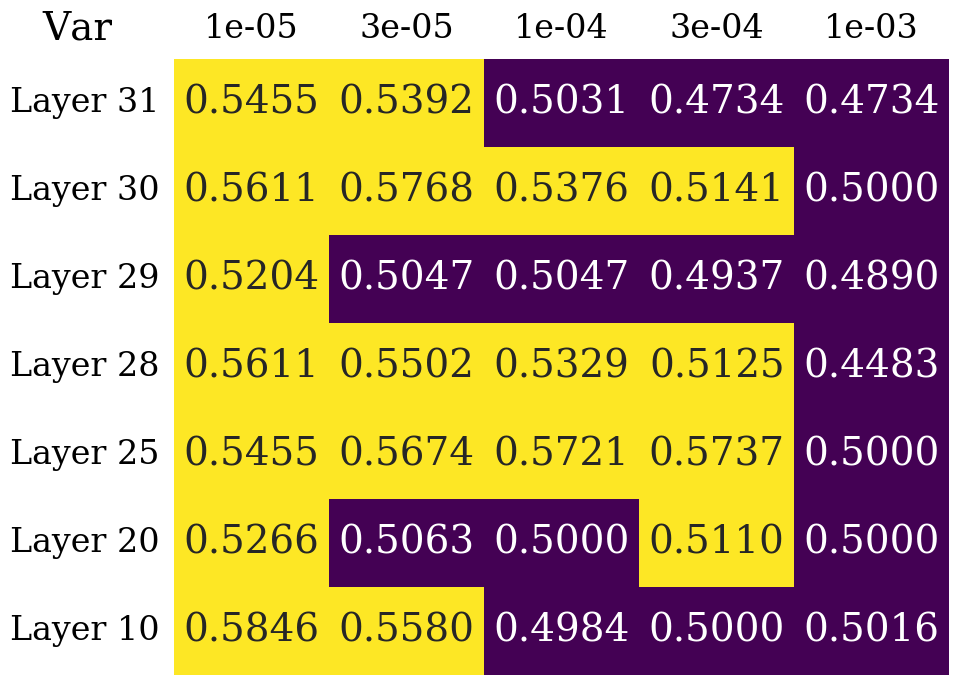

In [107]:
model = 'Mistral'
fixed_mlp_type = 'gate_proj'
title = f"{model} {task} ({fixed_mlp_type})"

fig, ax = get_superglue_colored_tables(mistral_metrics, mistral_unwatermarked, task, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = llama_unwatermarked[task][TASKS[task]]
unwat_std = llama_unwatermarked[task][TASKS[task] + '_stderr']
print(f"Unwatermarked: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")
plt.show()

Unwatermarked: 0.5157 +/- 0.0198
Unwatermarked (Normalized): (0.9616, 1.0384)


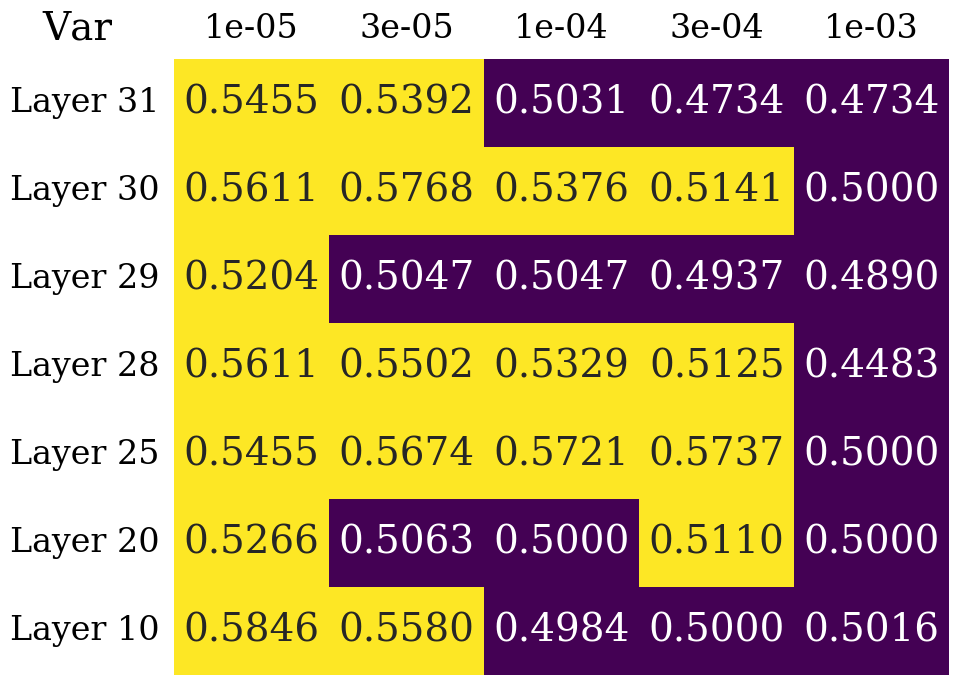

In [108]:
model = 'Mistral'
fixed_mlp_type = 'gate_proj'
title = f"{model} {task} ({fixed_mlp_type})"

fig, ax = get_superglue_colored_tables(mistral_metrics, mistral_unwatermarked, task, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = llama_unwatermarked[task][TASKS[task]]
unwat_std = llama_unwatermarked[task][TASKS[task] + '_stderr']
print(f"Unwatermarked: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")
plt.show()

## GSM8K Colored Tables

Unwatermarked GSM8K: 0.8423 +/- 0.0100
Unwatermarked GSM8K (Normalized): (0.9881, 1.0119)


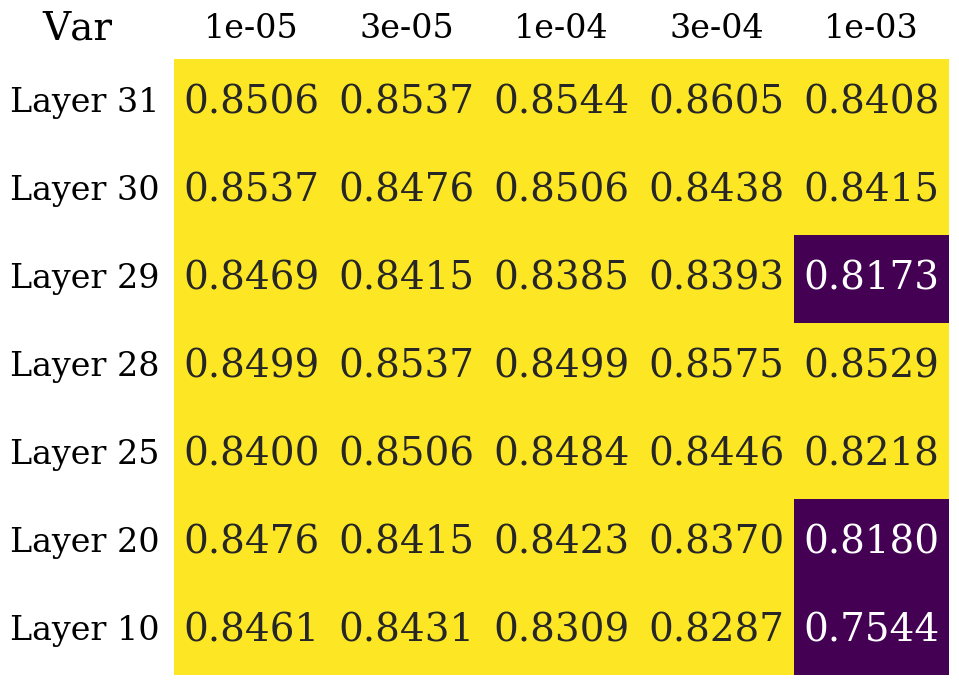

In [109]:
model = 'Phi'
fixed_mlp_type = 'gate_up_proj'
title = f"{model} GSM8K ({fixed_mlp_type})"

fig, ax = get_gsm8k_colored_tables(phi_metrics, phi_unwatermarked, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = phi_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract']
unwat_std = phi_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract_stderr']

print(f"Unwatermarked GSM8K: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked GSM8K (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f"phi_gsm8k_{fixed_mlp_type}.pdf"))

plt.show()

Unwatermarked GSM8K: 0.8423 +/- 0.0100
Unwatermarked GSM8K (Normalized): (0.9881, 1.0119)


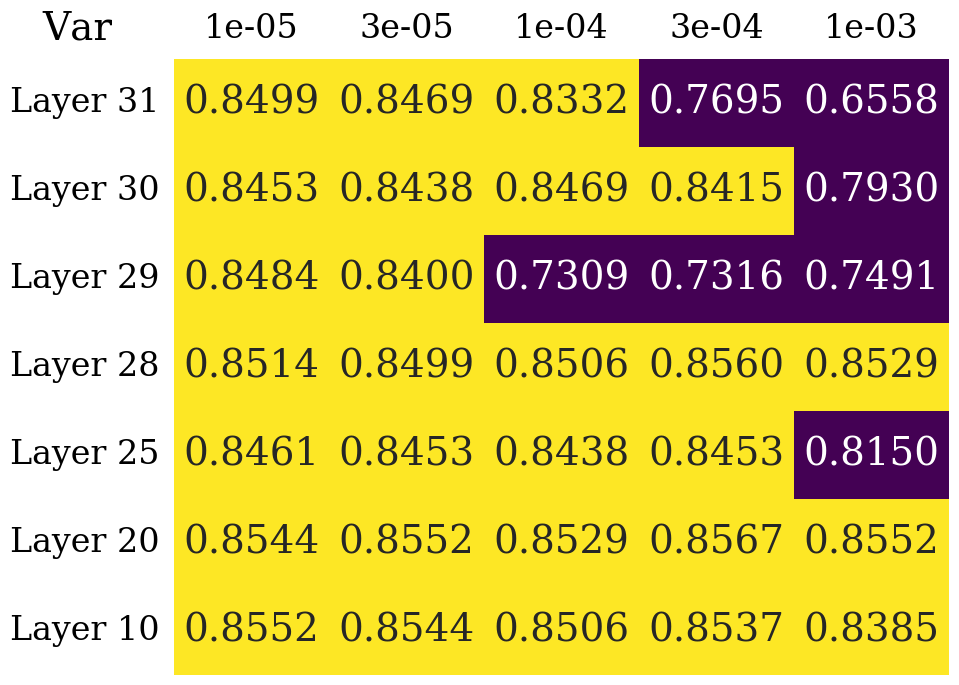

In [110]:
fixed_mlp_type = 'down_proj'
title = f"{model} GSM8K ({fixed_mlp_type})"

fig, ax = get_gsm8k_colored_tables(phi_metrics, phi_unwatermarked, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = phi_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract']
unwat_std = phi_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract_stderr']

print(f"Unwatermarked GSM8K: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked GSM8K (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, f"phi_gsm8k_{fixed_mlp_type}.pdf"))

plt.show()

Unwatermarked GSM8K: 0.6300 +/- 0.0133
Unwatermarked GSM8K (Normalized): (0.9789, 1.0211)


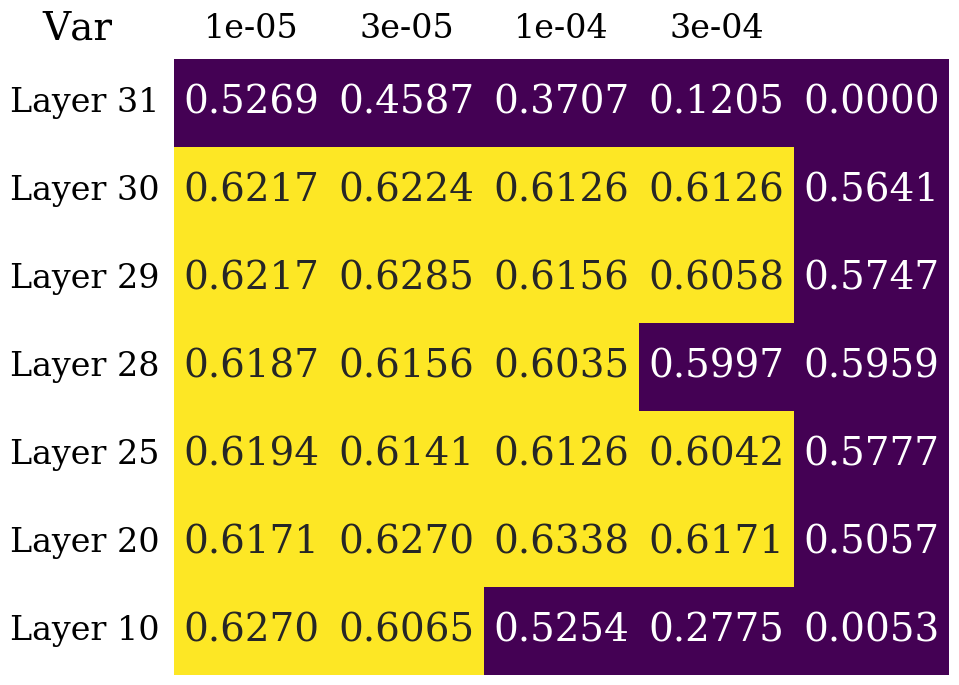

In [111]:
model = 'Llama'
fixed_mlp_type = 'down_proj'
title = f"{model} GSM8K ({fixed_mlp_type})"

fig, ax = get_gsm8k_colored_tables(llama_metrics, llama_unwatermarked, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = llama_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract']
unwat_std = llama_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract_stderr']

print(f"Unwatermarked GSM8K: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked GSM8K (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, f"llama_gsm8k_{fixed_mlp_type}.pdf"))

plt.show()

Unwatermarked GSM8K: 0.6300 +/- 0.0133
Unwatermarked GSM8K (Normalized): (0.9789, 1.0211)


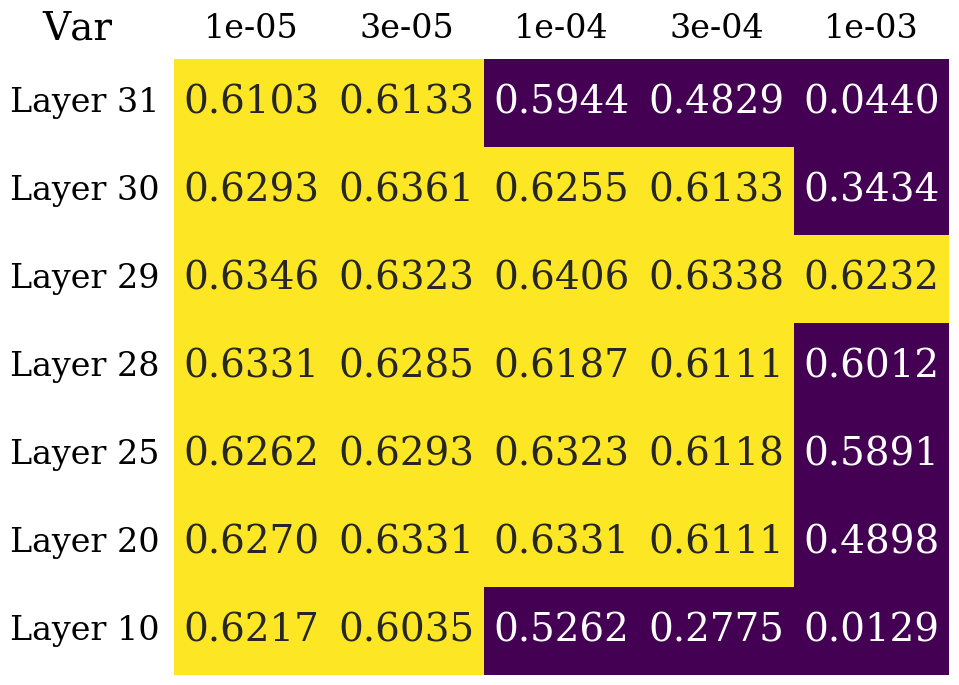

In [112]:
model = 'Llama'
fixed_mlp_type = 'up_proj'
title = f"{model} GSM8K ({fixed_mlp_type})"

fig, ax = get_gsm8k_colored_tables(llama_metrics, llama_unwatermarked, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = llama_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract']
unwat_std = llama_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract_stderr']

print(f"Unwatermarked GSM8K: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked GSM8K (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, f"llama_gsm8k_{fixed_mlp_type}.pdf"))

plt.show()

Unwatermarked GSM8K: 0.6300 +/- 0.0133
Unwatermarked GSM8K (Normalized): (0.9789, 1.0211)


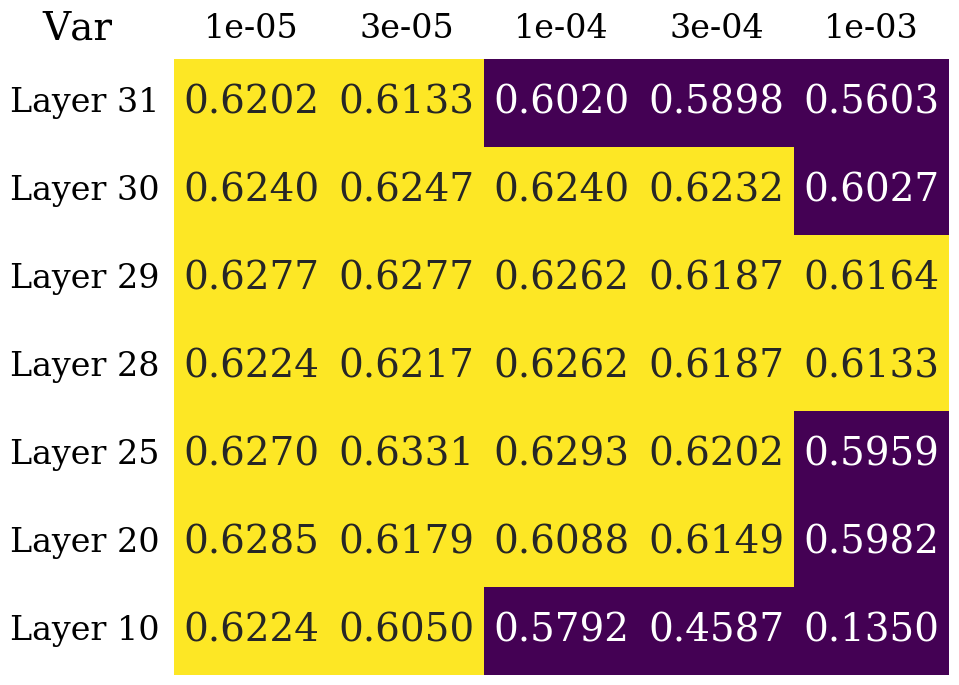

In [113]:
model = 'Llama'
fixed_mlp_type = 'gate_proj'
title = f"{model} GSM8K ({fixed_mlp_type})"

fig, ax = get_gsm8k_colored_tables(llama_metrics, llama_unwatermarked, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = llama_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract']
unwat_std = llama_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract_stderr']

print(f"Unwatermarked GSM8K: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked GSM8K (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"llama_gsm8k_{fixed_mlp_type}.pdf"))
plt.show()

Unwatermarked GSM8K: 0.4291 +/- 0.0136
Unwatermarked GSM8K (Normalized): (0.9682, 1.0318)


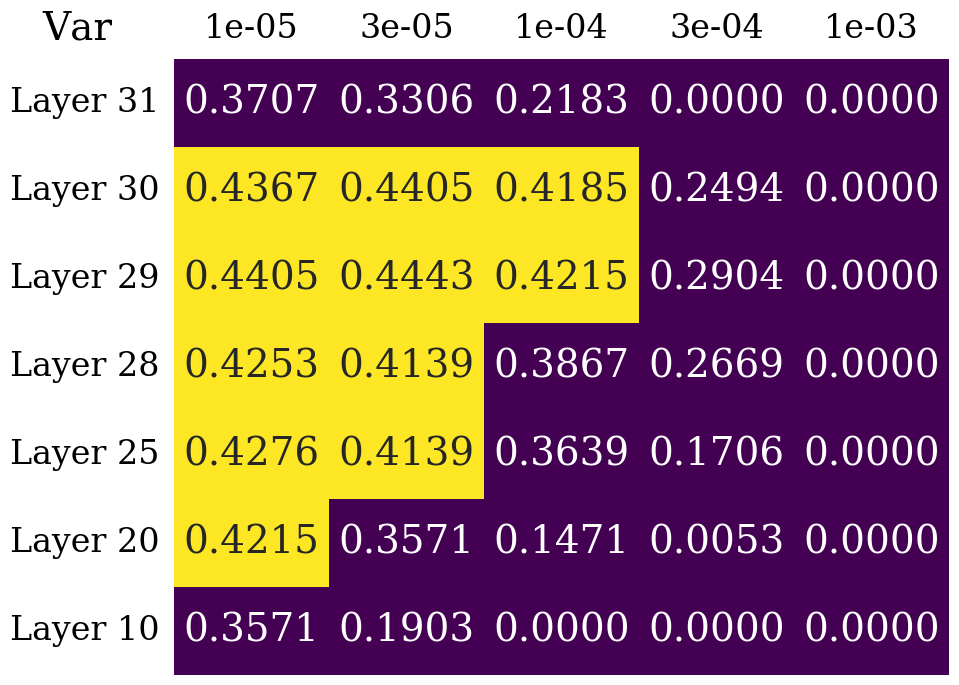

In [114]:
model = 'Mistral'
fixed_mlp_type = 'down_proj'
title = f"{model} GSM8K ({fixed_mlp_type})"

fig, ax = get_gsm8k_colored_tables(mistral_metrics, mistral_unwatermarked, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = mistral_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract']
unwat_std = mistral_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract_stderr']

print(f"Unwatermarked GSM8K: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked GSM8K (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"mistral_gsm8k_{fixed_mlp_type}.pdf"))
plt.show()

Unwatermarked GSM8K: 0.4291 +/- 0.0136
Unwatermarked GSM8K (Normalized): (0.9682, 1.0318)


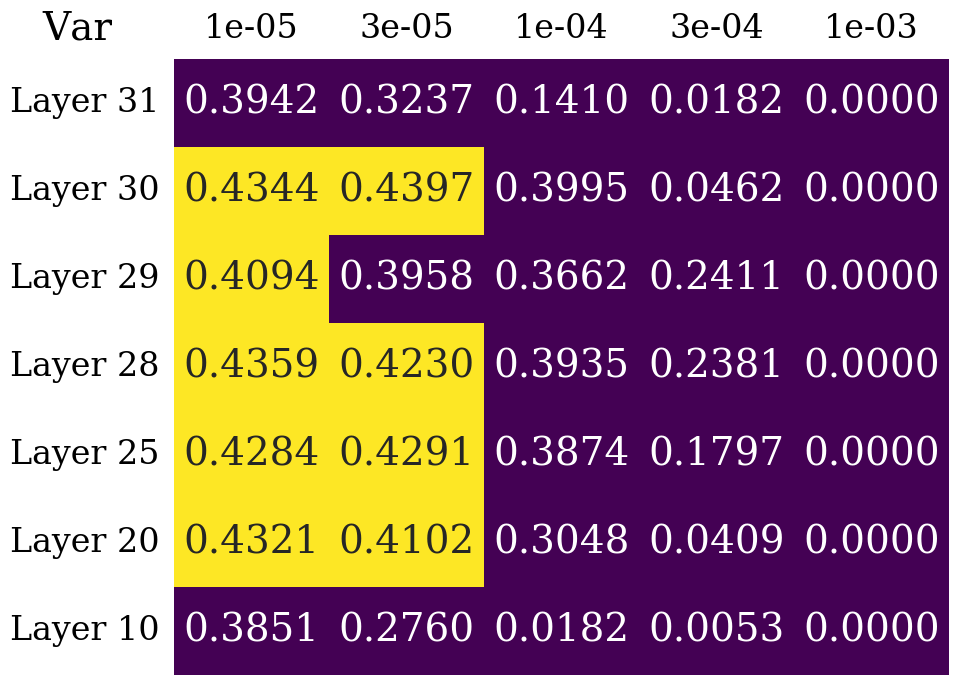

In [115]:
model = 'Mistral'
fixed_mlp_type = 'up_proj'
title = f"{model} GSM8K ({fixed_mlp_type})"

fig, ax = get_gsm8k_colored_tables(mistral_metrics, mistral_unwatermarked, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = mistral_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract']
unwat_std = mistral_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract_stderr']

print(f"Unwatermarked GSM8K: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked GSM8K (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"mistral_gsm8k_{fixed_mlp_type}.pdf"))
plt.show()

Unwatermarked GSM8K: 0.4291 +/- 0.0136
Unwatermarked GSM8K (Normalized): (0.9682, 1.0318)


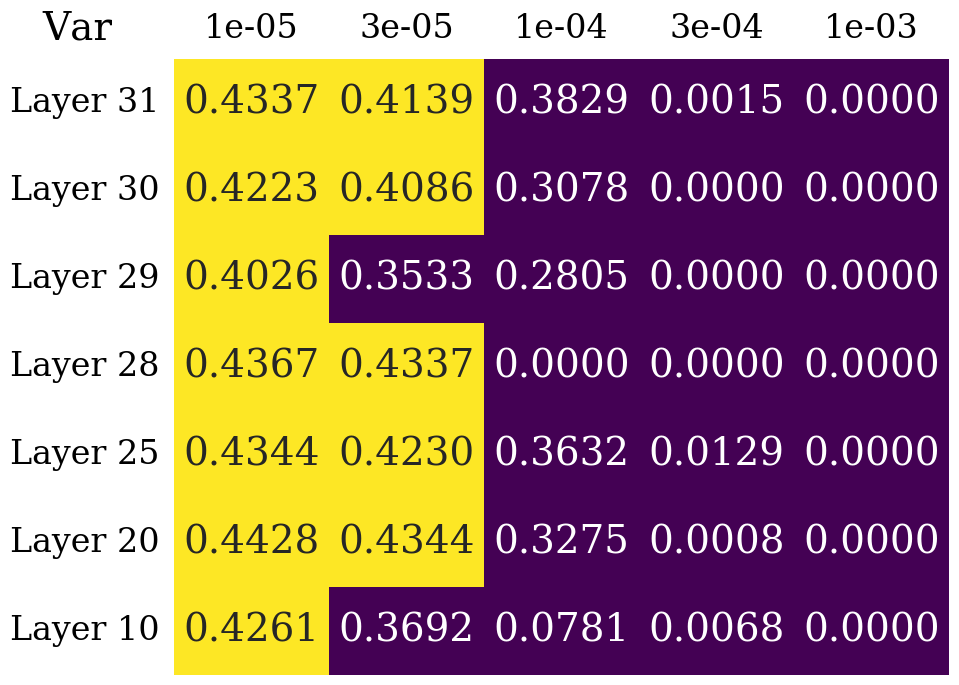

In [116]:
model = 'Mistral'
fixed_mlp_type = 'gate_proj'
title = f"{model} GSM8K ({fixed_mlp_type})"

fig, ax = get_gsm8k_colored_tables(mistral_metrics, mistral_unwatermarked, fixed_mlp_type)
# ax.set_title(title, y=1.12)

unwat_mean = mistral_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract']
unwat_std = mistral_unwatermarked['gsm8k_cot_self_consistency']['exact_match,flexible-extract_stderr']

print(f"Unwatermarked GSM8K: {unwat_mean:.4f} +/- {unwat_std:.4f}")
print(f"Unwatermarked GSM8K (Normalized): ({1 - unwat_std / unwat_mean:.4f}, {1 + unwat_std / unwat_mean:.4f})")
if save_figs:
    fig.savefig(os.path.join(figs_parent, f"mistral_gsm8k_{fixed_mlp_type}.pdf"))
plt.show()

# Getting metrics of Good models

In [117]:
good_models = {
    'Mistral':  ('model.layers.20.mlp.up_proj.weight', 1e-05, 0), # ('model.layers.30.mlp.gate_proj.weight', 1e-05, 0), # ('model.layers.28.mlp.up_proj.weight', 1e-05, 0), #
    'Llama': ('model.layers.28.mlp.up_proj.weight', 0.0003, 0),
    'Phi':    ('model.layers.20.mlp.down_proj.weight', 0.001, 0),
}
task_names ={
    'boolq': 'BoolQ',
    'cb': 'CB',
    'copa': 'COPA',
    'multirc': 'MultiRC',
    'record': 'ReCoRD',
    'rte': 'RTE',
    'wic': 'WiC',
    'wsc': 'Winograd'
}
task_metrics = {
    'boolq': 'acc',
    'cb': 'acc',
    'copa': 'acc',
    'multirc': 'acc',
    'record': 'f1',
    'rte': 'acc',
    'wic': 'acc',
    'wsc': 'acc'
}

In [118]:
table_str = "\\toprule \\textbf{Task} & \\textbf{Llama} & \\textbf{Llama (Unwatermarked)} \\\\ \n"

metric_dict = llama_metrics
param = good_models['Llama']
metric_dict = metric_dict[param]
unwatermarked_metrics = llama_unwatermarked



for task in task_names.keys():
    task_name = task_names[task]
    metric = task_metrics[task]
    mean = metric_dict[task][metric]
    std = metric_dict[task][metric + '_stderr']
    unwat_mean = unwatermarked_metrics[task][metric]
    unwat_std = unwatermarked_metrics[task][metric + '_stderr']
    temp_str = "\\textbf{" + task_name + "} & " + f"{mean:.4f} $\\pm$ {std:.4f} & {unwat_mean:.4f} $\\pm$ {unwat_std:.4f} \\\\ \n"
    table_str += temp_str

table_str += "\\bottomrule"


print(table_str)

\toprule \textbf{Task} & \textbf{Llama} & \textbf{Llama (Unwatermarked)} \\ 
\textbf{BoolQ} & 0.8223 $\pm$ 0.0067 & 0.8217 $\pm$ 0.0067 \\ 
\textbf{CB} & 0.6607 $\pm$ 0.0638 & 0.6250 $\pm$ 0.0653 \\ 
\textbf{COPA} & 0.9000 $\pm$ 0.0302 & 0.8700 $\pm$ 0.0338 \\ 
\textbf{MultiRC} & 0.5718 $\pm$ 0.0071 & 0.5720 $\pm$ 0.0071 \\ 
\textbf{ReCoRD} & 0.9168 $\pm$ 0.0027 & 0.9222 $\pm$ 0.0026 \\ 
\textbf{RTE} & 0.6931 $\pm$ 0.0278 & 0.7040 $\pm$ 0.0275 \\ 
\textbf{WiC} & 0.5047 $\pm$ 0.0198 & 0.5157 $\pm$ 0.0198 \\ 
\textbf{Winograd} & 0.6058 $\pm$ 0.0482 & 0.5865 $\pm$ 0.0485 \\ 
\bottomrule


In [119]:
table_str = "\\toprule \\textbf{Task} & \\textbf{Mistral} & \\textbf{Mistral (Unwatermarked)} \\\\ \n"

metric_dict = mistral_metrics
param = good_models['Mistral']
metric_dict = metric_dict[param]
unwatermarked_metrics = mistral_unwatermarked



for task in task_names.keys():
    task_name = task_names[task]
    metric = task_metrics[task]
    mean = metric_dict[task][metric]
    std = metric_dict[task][metric + '_stderr']
    unwat_mean = unwatermarked_metrics[task][metric]
    unwat_std = unwatermarked_metrics[task][metric + '_stderr']
    temp_str = "\\textbf{" + task_name + "} & " + f"{mean:.4f} $\\pm$ {std:.4f} & {unwat_mean:.4f} $\\pm$ {unwat_std:.4f} \\\\ \n"
    table_str += temp_str

table_str += "\\bottomrule"
print(table_str)

\toprule \textbf{Task} & \textbf{Mistral} & \textbf{Mistral (Unwatermarked)} \\ 
\textbf{BoolQ} & 0.8162 $\pm$ 0.0068 & 0.8205 $\pm$ 0.0067 \\ 
\textbf{CB} & 0.6071 $\pm$ 0.0659 & 0.5357 $\pm$ 0.0672 \\ 
\textbf{COPA} & 0.9100 $\pm$ 0.0288 & 0.9200 $\pm$ 0.0273 \\ 
\textbf{MultiRC} & 0.5590 $\pm$ 0.0071 & 0.5672 $\pm$ 0.0071 \\ 
\textbf{ReCoRD} & 0.9203 $\pm$ 0.0027 & 0.9219 $\pm$ 0.0026 \\ 
\textbf{RTE} & 0.7112 $\pm$ 0.0273 & 0.6823 $\pm$ 0.0280 \\ 
\textbf{WiC} & 0.5831 $\pm$ 0.0195 & 0.5674 $\pm$ 0.0196 \\ 
\textbf{Winograd} & 0.5192 $\pm$ 0.0492 & 0.4615 $\pm$ 0.0491 \\ 
\bottomrule


In [120]:
table_str = "\\toprule \\textbf{Task} & \\textbf{Phi} & \\textbf{Phi (Unwatermarked)} \\\\ \n"

metric_dict = phi_metrics
param = good_models['Phi']
metric_dict = metric_dict[param]
unwatermarked_metrics = phi_unwatermarked



for task in task_names.keys():
    task_name = task_names[task]
    metric = task_metrics[task]
    mean = metric_dict[task][metric]
    std = metric_dict[task][metric + '_stderr']
    unwat_mean = unwatermarked_metrics[task][metric]
    unwat_std = unwatermarked_metrics[task][metric + '_stderr']
    temp_str = "\\textbf{" + task_name + "} & " + f"{mean:.4f} $\\pm$ {std:.4f} & {unwat_mean:.4f} $\\pm$ {unwat_std:.4f} \\\\ \n"
    table_str += temp_str

table_str += "\\bottomrule"
print(table_str)

\toprule \textbf{Task} & \textbf{Phi} & \textbf{Phi (Unwatermarked)} \\ 
\textbf{BoolQ} & 0.8514 $\pm$ 0.0062 & 0.8532 $\pm$ 0.0062 \\ 
\textbf{CB} & 0.0893 $\pm$ 0.0385 & 0.0893 $\pm$ 0.0385 \\ 
\textbf{COPA} & 0.8800 $\pm$ 0.0327 & 0.8700 $\pm$ 0.0338 \\ 
\textbf{MultiRC} & 0.3855 $\pm$ 0.0070 & 0.3296 $\pm$ 0.0068 \\ 
\textbf{ReCoRD} & 0.8689 $\pm$ 0.0033 & 0.8725 $\pm$ 0.0033 \\ 
\textbf{RTE} & 0.7509 $\pm$ 0.0260 & 0.7509 $\pm$ 0.0260 \\ 
\textbf{WiC} & 0.5768 $\pm$ 0.0196 & 0.5752 $\pm$ 0.0196 \\ 
\textbf{Winograd} & 0.7885 $\pm$ 0.0402 & 0.8269 $\pm$ 0.0373 \\ 
\bottomrule


# Getting Good Models

In [121]:
# frac_passed_threshold = 0.7
# sigfig_threshold = 0.05

frac_passed_threshold = 0.5
# sigfig_threshold = 0.001
sigfig_threshold = 0.0001

tolerance = 0.00
min_prob = 1e-20
include_gsm8k = True

llama_parents = [
    # '10-07-watermark-llama',
    # '10-09-watermark-llama-lowrank',
    '10-10-watermark-llama-lowrank'
]

phi_parents = [
    # '10-07-watermark-phi',
    # '10-09-watermark-phi-lowrank',
    '10-10-watermark-phi-lowrank'
]

mistral_parents = [
    # '10-07-watermark-mistral',
    '10-10-watermark-mistral-lowrank'
]

llama_parents = [os.path.join(amlt_parent, parent) for parent in llama_parents]
phi_parents = [os.path.join(amlt_parent, parent) for parent in phi_parents]
mistral_parents = [os.path.join(amlt_parent, parent) for parent in mistral_parents]


good_llama_models = get_good_models(llama_parents, fraction_passed_threshold=frac_passed_threshold, sigfig_threshold=sigfig_threshold, tolerance=tolerance, min_prob=min_prob, include_gsm8k=include_gsm8k, key_is_path=True)

# frac_passed_threshold = 0.7
# sigfig_threshold = 0.05
tolerance = 0.00
min_prob = 1e-20
include_gsm8k = True

good_phi_models = get_good_models(phi_parents, fraction_passed_threshold=frac_passed_threshold, sigfig_threshold=sigfig_threshold, tolerance=tolerance, min_prob=min_prob, include_gsm8k=include_gsm8k, key_is_path=True)

tolerance = 0.00
min_prob = 1e-20
include_gsm8k = True

good_mistral_models = get_good_models(mistral_parents, fraction_passed_threshold=frac_passed_threshold, sigfig_threshold=sigfig_threshold, tolerance=tolerance, min_prob=min_prob, include_gsm8k=include_gsm8k, key_is_path=True)

[Errno 2] No such file or directory: '/home/blockadam/gaussian-watermarking/amlt/10-10-watermark-llama-lowrank/grid_10-10-watermark-llama-lowrank_lay_30_mlp_gate_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_1024_var_3e-5/generations.json'
Error processing /home/blockadam/gaussian-watermarking/amlt/10-10-watermark-llama-lowrank/grid_10-10-watermark-llama-lowrank_lay_30_mlp_gate_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_1024_var_3e-5
Model failed gsm8k_cot_self_consistency test by 0.0118
Model failed boolq test by 0.0304
Model failed boolq test by 0.0618
Model failed boolq test by 0.0086
Model failed cb test by 0.0102
Model failed boolq test by 0.0301
Model failed boolq test by 0.0068
Model failed gsm8k_cot_self_consistency test by 0.0013
Model failed boolq test by 0.0089
Model failed record test by 0.0003
Model failed boolq test by 0.0080
Model failed boolq test by 0.0008
Model failed boolq test by 0.0991
Model failed boolq test by 0.0307
Model failed boolq test by 0.0576
Model failed reco

In [122]:
print("Good Llama Models" + '#' * 200 + '\n')

llama_parent = '10-10-watermark-llama-lowrank'
print_good_models(llama_parent, good_llama_models)

print('\n\nGood Phi Models' + '#' * 200 + '\n')
phi_parent = '10-10-watermark-phi-lowrank'
print_good_models(phi_parent, good_phi_models)

print('\n\nGood Mistral Models' + '#' * 200 + '\n')

mistral_parent = '10-10-watermark-mistral-lowrank'
print_good_models(mistral_parent, good_mistral_models)

Good Llama Models########################################################################################################################################################################################################

meta-llama/Meta-Llama-3.1-8B@___@1024@___@28@@@up_proj@@@weight@___@0.0003,10-10-watermark-llama-lowrank,grid_10-10-watermark-llama-lowrank_lay_28_mlp_up_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_1024_var_3e-4,0.961,False
meta-llama/Meta-Llama-3.1-8B@___@1024@___@31@@@gate_proj@@@weight@___@0.0003,10-10-watermark-llama-lowrank,grid_10-10-watermark-llama-lowrank_lay_31_mlp_gate_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_1024_var_3e-4,0.959,False
meta-llama/Meta-Llama-3.1-8B@___@512@___@28@@@up_proj@@@weight@___@0.0003,10-10-watermark-llama-lowrank,grid_10-10-watermark-llama-lowrank_lay_28_mlp_up_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_512_var_3e-4,0.953,False
meta-llama/Meta-Llama-3.1-8B@___@512@___@30@@@down_proj@@@weight@___@0.0001,10-10-watermark-llama-lowrank,grid_10

In [123]:
good_models_df = pd.read_csv('good_models.csv')
print(good_models_df.shape)
good_models_df = add_win_rates(good_models_df)

(148, 6)


In [124]:
good_models_df[good_models_df['exp_name'].isin({'10-10-watermark-llama-lowrank', '10-10-watermark-phi-lowrank', '10-10-watermark-mistral-lowrank'})].tail(50)

watermark_overrides  \
98   microsoft/Phi-3-mini-4k-instruct@___@512@___@3...   
99   microsoft/Phi-3-mini-4k-instruct@___@256@___@3...   
100  microsoft/Phi-3-mini-4k-instruct@___@256@___@2...   
101  microsoft/Phi-3-mini-4k-instruct@___@512@___@2...   
102  microsoft/Phi-3-mini-4k-instruct@___@1024@___@...   
103  microsoft/Phi-3-mini-4k-instruct@___@512@___@3...   
104  microsoft/Phi-3-mini-4k-instruct@___@1024@___@...   
105  microsoft/Phi-3-mini-4k-instruct@___@1024@___@...   
106  microsoft/Phi-3-mini-4k-instruct@___@256@___@3...   
107  microsoft/Phi-3-mini-4k-instruct@___@512@___@3...   
108  microsoft/Phi-3-mini-4k-instruct@___@256@___@2...   
109  microsoft/Phi-3-mini-4k-instruct@___@512@___@2...   
110  mistralai/Mistral-7B-v0.3@___@1024@___@30@@@up...   
111  mistralai/Mistral-7B-v0.3@___@1024@___@28@@@do...   
112  mistralai/Mistral-7B-v0.3@___@512@___@30@@@up_...   
113  mistralai/Mistral-7B-v0.3@___@64@___@30@@@up_p...   
114  mistralai/Mistral-7B-v0.3@___@256@___@30@@@up_...   
115  mistralai/Mistral-7B-v0.3@___@128@___@30@@@up_...   
116  mistralai/Mistral-7B-v0.3@___@128@___@29@@@up_...   
117  mistralai/Mistral-7B-v0.3@___@256@___@29@@@up_...   
118  mistralai/Mistral-7B-v0.3@___@512@___@29@@@up_...   
119  mistralai/Mistral-7B-v0.3@___@64@___@30@@@down...   
120  mistralai/Mistral-7B-v0.3@___@1024@___@29@@@up...   
121  mistralai/Mistral-7B-v0.3@___@512@___@28@@@up_...   
122  mistralai/Mistral-7B-v0.3@___@1024@___@28@@@up...   
123  mistralai/Mistral-7B-v0.3@___@128@___@28@@@up_...   
124  mistralai/Mistral-7B-v0.3@___@256@___@28@@@up_...   
125  mistralai/Mistral-7B-v0.3@___@64@___@28@@@up_p...   
126  mistralai/Mistral-7B-v0.3@___@128@___@29@@@dow...   
127  mistralai/Mistral-7B-v0.3@___@256@___@29@@@dow...   
128  mistralai/Mistral-7B-v0.3@___@64@___@29@@@down...   
129  mistralai/Mistral-7B-v0.3@___@512@___@30@@@dow...   
130  mistralai/Mistral-7B-v0.3@___@64@___@28@@@down...   
131  mistralai/Mistral-7B-v0.3@___@512@___@30@@@gat...   
132  mistralai/Mistral-7B-v0.3@___@256@___@28@@@dow...   
133  mistralai/Mistral-7B-v0.3@___@128@___@28@@@dow...   
134  mistralai/Mistral-7B-v0.3@___@64@___@30@@@gate...   
135  mistralai/Mistral-7B-v0.3@___@256@___@30@@@gat...   
136  mistralai/Mistral-7B-v0.3@___@512@___@29@@@dow...   
137  mistralai/Mistral-7B-v0.3@___@128@___@30@@@gat...   
138  mistralai/Mistral-7B-v0.3@___@512@___@28@@@dow...   
139  mistralai/Mistral-7B-v0.3@___@1024@___@30@@@do...   
140  mistralai/Mistral-7B-v0.3@___@1024@___@30@@@ga...   
141  mistralai/Mistral-7B-v0.3@___@1024@___@28@@@do...   
142  mistralai/Mistral-7B-v0.3@___@256@___@28@@@gat...   
143  mistralai/Mistral-7B-v0.3@___@1024@___@28@@@ga...   
144  mistralai/Mistral-7B-v0.3@___@64@___@28@@@gate...   
145  mistralai/Mistral-7B-v0.3@___@512@___@28@@@gat...   
146  mistralai/Mistral-7B-v0.3@___@128@___@28@@@gat...   
147  mistralai/Mistral-7B-v0.3@___@128@___@30@@@dow...   

                            exp_name  \
98       10-10-watermark-phi-lowrank   
99       10-10-watermark-phi-lowrank   
100      10-10-watermark-phi-lowrank   
101      10-10-watermark-phi-lowrank   
102      10-10-watermark-phi-lowrank   
103      10-10-watermark-phi-lowrank   
104      10-10-watermark-phi-lowrank   
105      10-10-watermark-phi-lowrank   
106      10-10-watermark-phi-lowrank   
107      10-10-watermark-phi-lowrank   
108      10-10-watermark-phi-lowrank   
109      10-10-watermark-phi-lowrank   
110  10-10-watermark-mistral-lowrank   
111  10-10-watermark-mistral-lowrank   
112  10-10-watermark-mistral-lowrank   
113  10-10-watermark-mistral-lowrank   
114  10-10-watermark-mistral-lowrank   
115  10-10-watermark-mistral-lowrank   
116  10-10-watermark-mistral-lowrank   
117  10-10-watermark-mistral-lowrank   
118  10-10-watermark-mistral-lowrank   
119  10-10-watermark-mistral-lowrank   
120  10-10-watermark-mistral-lowrank   
121  10-10-watermark-mistral-lowrank   
122  10-10-watermark-mistral-lowrank   
123  10-10-watermark-mistral-lowrank

In [125]:
idx = 131
print(f"{good_models_df.iloc[idx]['watermark_overrides']}: Win rate {good_models_df.iloc[idx]['win_rate']:.4f}, Frac Passed {good_models_df.iloc[idx]['frac_passed']:.4f}")



mistralai/Mistral-7B-v0.3@___@512@___@30@@@gate_proj@@@weight@___@1e-05: Win rate 0.5006, Frac Passed 0.9030


In [126]:
def plot_winrates_by_rank(df, title, plot_frac_passed=False):

    def _get_rank(row):
        return int(row['watermark_overrides'].split('@___@')[1])

    df2 = df.copy()
    df2['rank'] = df2.apply(_get_rank, axis=1)
    unique_ranks = df2['rank'].unique()
    unique_ranks.sort()
    win_rates = {}
    frac_passed = {}
    for rank in unique_ranks:
        sub_df = df2[df2['rank'] == rank]
        win_rates[rank] = sub_df['win_rate'].to_numpy()
        frac_passed[rank] = sub_df['frac_passed'].to_numpy()
    
    fig, ax = plt.subplots()

    alpha = 0.5
    bins = 20
    density = True
    for rank in unique_ranks:
        if plot_frac_passed:
            ax.hist(frac_passed[rank], label=f'Rank {rank}', bins=bins, alpha=alpha, density=density)
            ax.set_ylabel('Fraction Significant (Passed Threshold)')
        else:
            ax.hist(win_rates[rank], label=f'Rank {rank}', bins=bins, alpha=alpha, density=density)
            ax.set_ylabel('Win Rate')
    
    ax.legend()
    # ax.set_title(title)
    return fig, ax


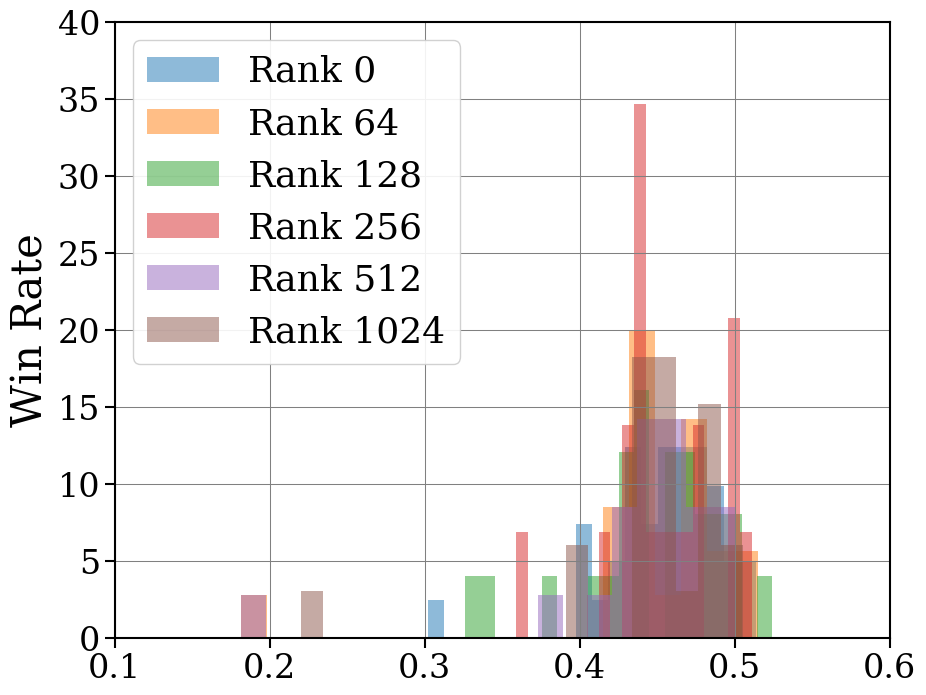

In [127]:
fig, ax  = plot_winrates_by_rank(good_models_df, 'Win Rates by Rank')
plt.show()

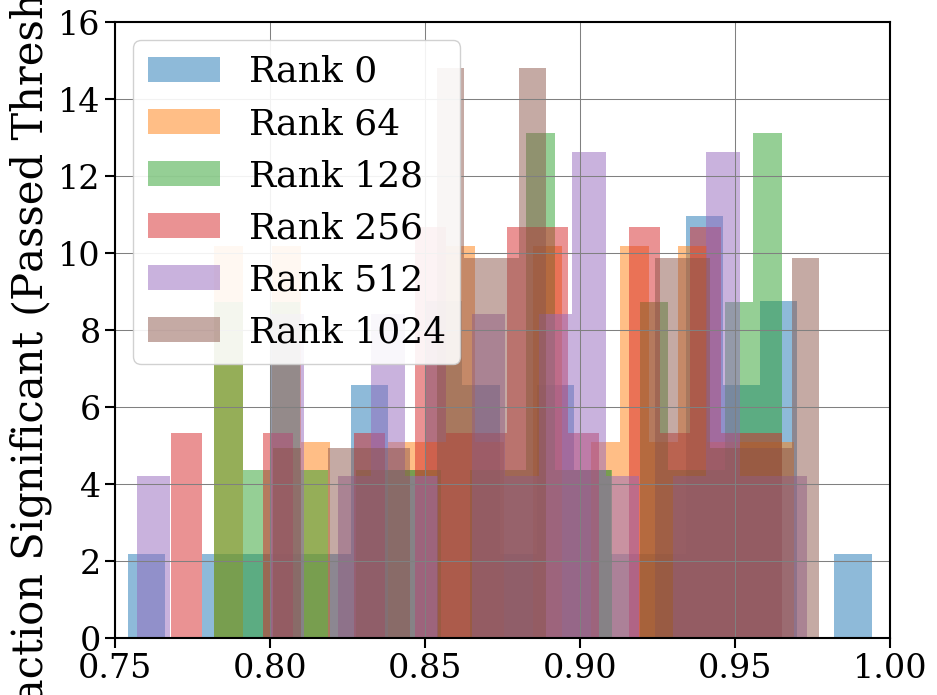

In [128]:
fig, ax  = plot_winrates_by_rank(good_models_df, 'Fraction Significant by Rank', plot_frac_passed=True)
plt.show()

In [129]:

good_models_df[good_models_df['win_rate'] >= good_models_df['baseline_mean']- 0.03][['watermark_overrides', 'frac_passed', 'win_rate']]

watermark_overrides  frac_passed  win_rate
0    meta-llama/Meta-Llama-3.1-8B@___@0@___@20@@@do...        0.969  0.398734
1    meta-llama/Meta-Llama-3.1-8B@___@0@___@28@@@up...        0.967  0.451654
2    meta-llama/Meta-Llama-3.1-8B@___@0@___@20@@@up...        0.965  0.434227
3    meta-llama/Meta-Llama-3.1-8B@___@0@___@25@@@do...        0.954  0.453503
4    meta-llama/Meta-Llama-3.1-8B@___@0@___@30@@@do...        0.945  0.441624
..                                                 ...          ...       ...
134  mistralai/Mistral-7B-v0.3@___@64@___@30@@@gate...        0.890  0.474874
135  mistralai/Mistral-7B-v0.3@___@256@___@30@@@gat...        0.890  0.496847
137  mistralai/Mistral-7B-v0.3@___@128@___@30@@@gat...        0.886  0.466328
140  mistralai/Mistral-7B-v0.3@___@1024@___@30@@@ga...        0.881  0.486146
143  mistralai/Mistral-7B-v0.3@___@1024@___@28@@@ga...        0.862  0.476612

[108 rows x 3 columns]

In [130]:
good_models_df['watermark_overrides'].iloc[29]

'mistralai/Mistral-7B-v0.3@___@0@___@20@@@up_proj@@@weight@___@1e-05'

# Get times

In [131]:
phi_generation_times, phi_detection_times = get_detection_times('./amlt/logs/10-07-watermark-phi')
llama_generation_times, llama_detection_times = get_detection_times('./amlt/logs/10-07-watermark-llama')
mistral_generation_times, mistral_detection_times = get_detection_times('./amlt/logs/10-07-watermark-mistral')

Error with grid_10-07-watermark-mistral_lay_30_mlp_down_proj_mod_mistralai_Mistral-7B-v0.3_ran_0_var_1e-4
local variable 'gen_time' referenced before assignment


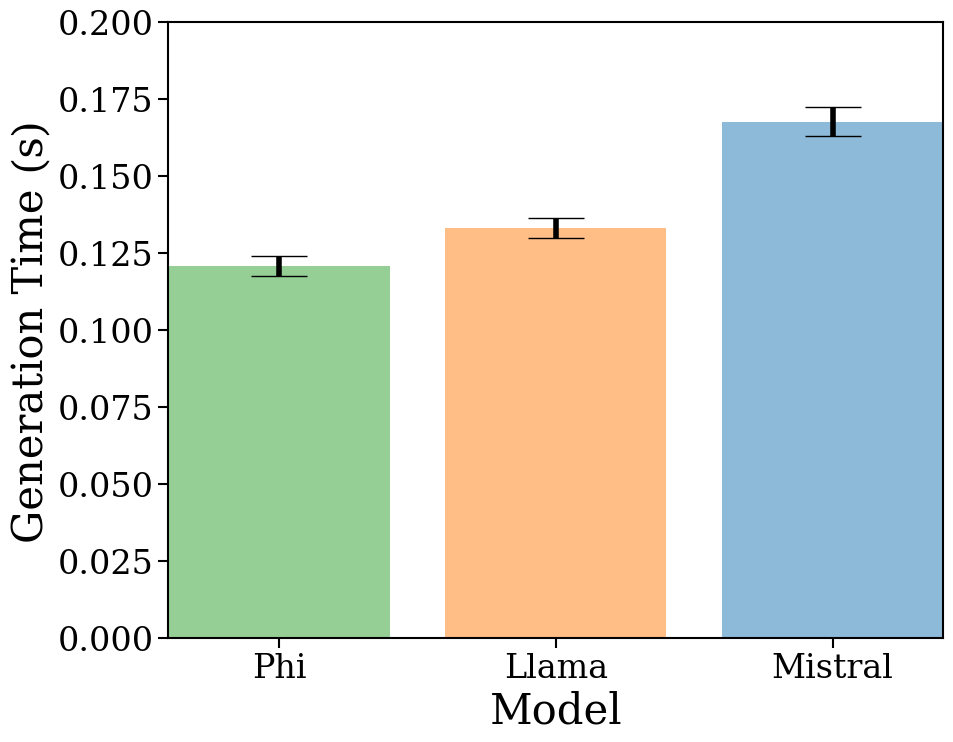

In [132]:
fig, ax = plt.subplots()

labels = ['Phi', 'Llama', 'Mistral']
generation_time_means = [np.mean(phi_generation_times), np.mean(llama_generation_times), np.mean(mistral_generation_times)]
generation_time_std = [np.std(phi_generation_times), np.std(llama_generation_times), np.std(mistral_generation_times)]

# labels = ['Phi', 'Llama']
# generation_time_means = [np.mean(phi_generation_times), np.mean(llama_generation_times)]
# generation_time_std = [np.std(phi_generation_times), np.std(llama_generation_times)]



generation_time_std_error = [x / np.sqrt(len(phi_generation_times)) for x in generation_time_std]

ax.bar(labels, generation_time_means, yerr=generation_time_std_error, capsize=20, alpha=0.5, color=[default_cycler[2], default_cycler[1], default_cycler[0]])
ax.set_ylabel('Generation Time (s)')
ax.set_xlabel('Model')
ax.grid()

# fig.suptitle('Generation (1K Tokens)')




plt.show()

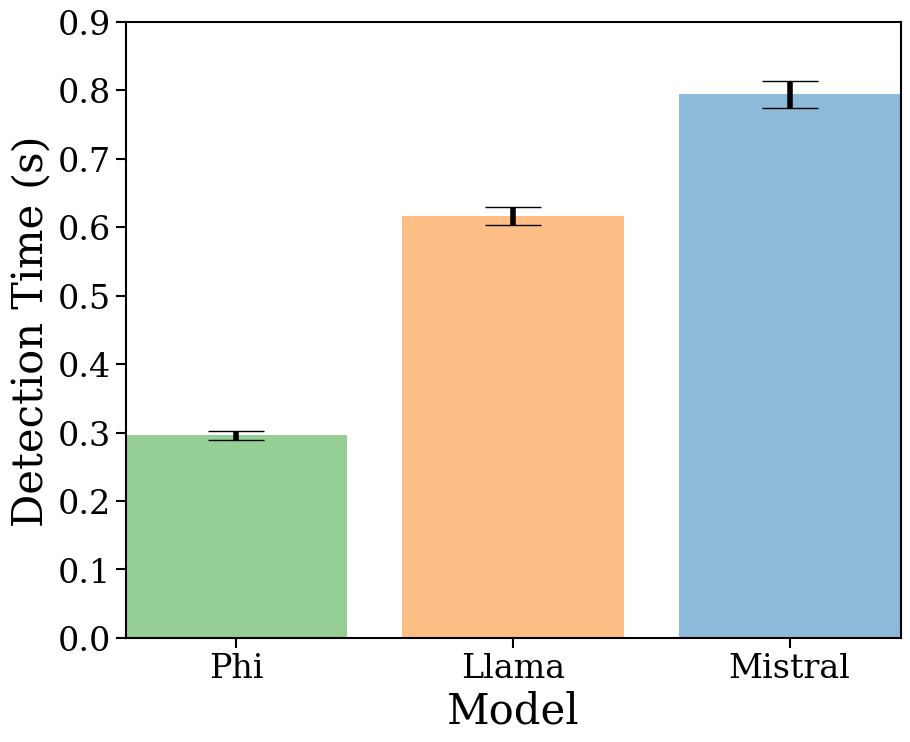

In [133]:
fig, ax = plt.subplots()

labels = ['Phi', 'Llama', 'Mistral']
detection_time_means = [np.mean(phi_detection_times), np.mean(llama_detection_times), np.mean(mistral_detection_times)]
detection_time_std = [np.std(phi_detection_times), np.std(llama_detection_times), np.std(mistral_detection_times)]

# labels = ['Phi', 'Llama']
# detection_time_means = [np.mean(phi_detection_times), np.mean(llama_detection_times)]
# detection_time_std = [np.std(phi_detection_times), np.std(llama_detection_times)]


detection_time_std_error = [x / np.sqrt(len(phi_detection_times)) for x in detection_time_std]

ax.bar(labels, detection_time_means, yerr=detection_time_std_error, alpha=0.5, capsize=20, color=[default_cycler[2], default_cycler[1], default_cycler[0]])

ax.set_xlabel('Model')
ax.set_ylabel('Detection Time (s)')
ax.grid()
# fig.suptitle('Detection (1k Tokens)')

plt.show()

In [134]:
numtokens_parent = os.path.join(amlt_parent, 'logs', '10-11-watermark-numtokens.yaml')
numtokens_gen_times, numtokens_det_times = get_num_tokens_times_seeds([numtokens_parent])

Error with grid_10-11-watermark-numtokens.yaml_max_1000_see_133341_wat_meta-llama_Meta-Llama-3.1-8B_____0_____28___up_proj___weight_____0.0003
local variable 'gen_time' referenced before assignment


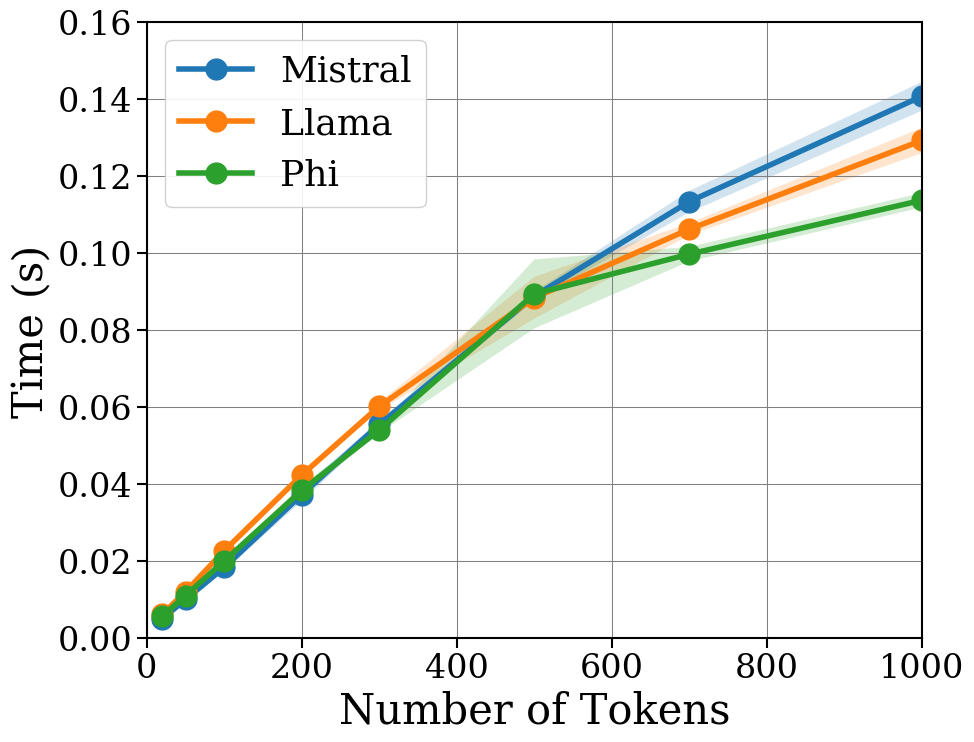

In [135]:
fig, ax = plt.subplots()

model_mappings = {
    'Mistral': 'mistralai/Mistral-7B-v0.3',
    'Llama': 'meta-llama/Meta-Llama-3.1-8B',
    'Phi': 'microsoft/Phi-3-mini-4k-instruct',
}

for model_alias, model_name in model_mappings.items():
    numtokens_times = numtokens_gen_times[model_name]
    numtokens, lbs, ubs, means = get_numtokens_times_lbs_ubs_means(numtokens_times)
    ax.plot(numtokens, means, label=model_alias, marker='o')
    ax.fill_between(numtokens, lbs, ubs, alpha=0.2)

ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Time (s)')
# ax.set_title('Generation Time by Number of Tokens')

ax.set_ylim(0)
ax.legend()
plt.show()


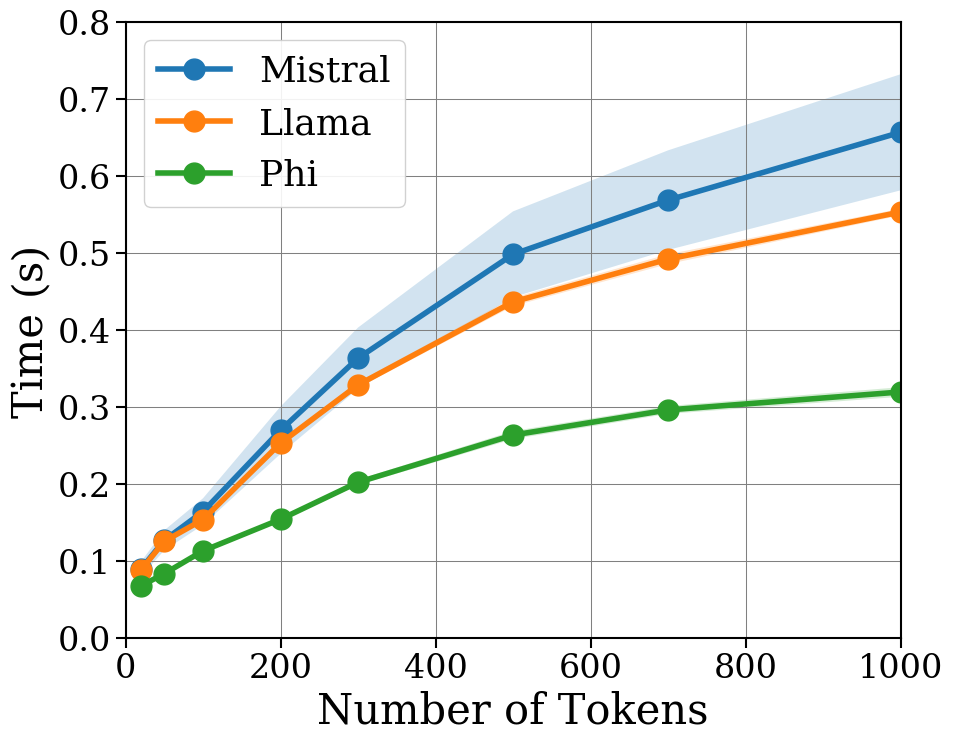

In [136]:
fig, ax = plt.subplots()

for model_alias, model_name in model_mappings.items():
    numtokens_times = numtokens_det_times[model_name]
    numtokens, lbs, ubs, means = get_numtokens_times_lbs_ubs_means(numtokens_times)
    ax.plot(numtokens, means, label=model_alias, marker='o')
    ax.fill_between(numtokens, lbs, ubs, alpha=0.2)

ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Time (s)')
# ax.set_title('Detection Time by Number of Tokens')

ax.set_ylim(0)
ax.legend()
plt.show()
